# Prediction of result of MLS Soccer Match in 2024 season

## Scraping Data and initial Feature Selection

In this section we try to scrape from famous website [FBRef](https://fbref.com/it/) all the possible data we need for our model that we want to build. We will extract 2019,2021,2022,2023 (2020 was a strange year, for the reason everyone knows, and I decided to ignore it) and part of 2024 so that we have more than 1500 matches at our disposal as dataset.

In [1]:
import soccerdata as sd
import pandas as pd
import numpy as np
import time
import warnings
from datetime import datetime
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning)

[06/24/24 12:10:40] INFO     Custom team name replacements loaded from                                _config.py:85
                             /Users/gabrielmasella/soccerdata/config/teamname_replacements.json.                   

                    INFO     Custom league dict loaded from                                          _config.py:180
                             /Users/gabrielmasella/soccerdata/config/league_dict.json.                             

In [2]:
fbref= sd.FBref(leagues="USA-Major League Soccer", seasons=[x for x in range(2019,2025)])
#fbref = sd.FBref(leagues="USA-Major League Soccer", seasons=[2021,2022,2023])
mls_schedule_fbref = fbref.read_schedule()
mls_schedule_fbref.info()
mls_schedule_fbref.columns
mls_schedule_fbref.describe()

mls_schedule_fbref.shape   #dimension of the data

mls_teams = mls_schedule_fbref["home_team"].unique() #unique teams in the data

mls_teams = np.sort(mls_teams) #sort the teams alphabetically

[06/23/24 15:16:15] INFO     Saving cached data to C:\Users\anank\soccerdata\data\FBref               ]8;id=431976;file://c:\Users\anank\Documents\VisualStudio\.venv\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=689016;file://c:\Users\anank\Documents\VisualStudio\.venv\Lib\site-packages\soccerdata\_common.py#92\92]8;;\

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2396 entries, ('USA-Major League Soccer', '1920', '2019-03-02 Colombus Crew-NY Red Bulls') to ('USA-Major League Soccer', '2425', '2024-10-19 Seattle-Portland Timbers')
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   round         1903 non-null   string        
 1   day           2396 non-null   string        
 2   date          2396 non-null   datetime64[ns]
 3   time          2394 non-null   string        
 4   home_team     2396 non-null   string        
 5   home_xg       2182 non-null   Float64       
 6   score         2182 non-null   string        
 7   away_xg       2182 non-null   Float64       
 8   away_team     2396 non-null   string        
 9   attendance    2041 non-null   Int64         
 10  venue         2394 non-null   string        
 11  referee       2182 non-null   string        
 12  match_report  2182 non-null   object       

### Feature Selection

Ok, so far we have done all the data scraping proceure with a preliminary cleaning only of the first "schedule" table, but now we have to throw away all the useless columns and above all make sure to create datasets where each time we take for each match the right features, useful to create our Machine Learning model.
Here a brief review of the feature that we'll select and a reason of why:
- from "Scores & Fixtures"
    - "Date" and "Season" for organization reason of data, but they will not be used in the training data;
    - "GF" and "GA" could be probably our target, so technically, in order to know who will win, we want to predict how how many goals the two teams will score;
    - "Opponent" for organization reason but effectly it will not be encoded in ML algorithms because we don't want bias given by the teams;
    - "Possession" it's and indicator of how a team dominates in the field
    - "Formation" it's important because number of midfielder, defender and striker tell us the approach of the team
- from "Shooting"
    - "Shot" and Shot on Target" in order to calculate a mean of how much a team is offensive and how much is capable to break opponent's defense;
    - "Standard - G/Sh" and "Standard G/SoT" could be interesting parameters, to replace the one befores
    - "Standard - Dist", that is average distance of shot could be added
- from "Goalkeeping" we use only some parameters 
    - "Performance - Saves%" is the ratio in probability of saves made by the goalkeeper for shot recieved 
    - "Launched - Cmp%"
    - "Passes - Launch%"
    - "Passes - AvgLen"
    - "Goal Kicks - Launch%"
    - "Goal Kicks - AvgLen"
- from "Passing"
    - ""



In [3]:
feature_singlematch=["schedule","keeper","shooting","passing","passing_types","goal_shot_creation","defense","possession","misc"]

data_frames = []

for team in mls_teams:
    team_data_frames = [] 
    for i in feature_singlematch:
        team_match_stats = fbref.read_team_match_stats(stat_type=i,team=team)
        if i == "schedule":
            team_match_stats = team_match_stats.drop(columns=["round","day","venue","Attendance","Captain","Referee","match_report","Notes"])
        else:  
            team_match_stats = team_match_stats.iloc[:, 8:]  # Drop the first eight columns
            team_match_stats = team_match_stats.iloc[:, :-2] #drop the last two columns
            if i == "keeper":
                team_match_stats = team_match_stats[[
                    ('Performance', 'SoTA'),
                    ('Performance', 'Saves')
                ]]
            elif i == "shooting":
                team_match_stats = team_match_stats[[
                    ('Standard', 'Sh'),
                    ('Standard', 'SoT'),
                    ('Standard', 'Dist')
                ]]
            elif i == "passing":
                team_match_stats = team_match_stats[[
                    ('Total', 'Cmp'),
                    ('Total', 'Att'),
                    ('Short', 'Cmp'),
                    ('Short', 'Att'),
                    ('Medium', 'Cmp'),
                    ('Medium', 'Att'),
                    ('Long', 'Cmp'),
                    ('Long', 'Att'),
                    ('Ast', ''),
                    ('KP', ''),
                    ('1/3', ''),
                    ('PPA', ''),
                    ('CrsPA', ''),
                    ('PrgP', '')
                ]]
            elif i == "passing_types":
                team_match_stats = team_match_stats[[
                    ('Pass Types', 'Crs'),
                    ('Pass Types', 'TI'),
                    ('Pass Types', 'CK')
                ]]
            elif i == "goal_shot_creation":
                team_match_stats = team_match_stats[[
                    ('SCA Types', 'SCA'),
                    ('GCA Types', 'GCA')
                ]]
            elif i == "defense":
                team_match_stats = team_match_stats[[
                    ('Tackles', 'Tkl'),
                    ('Tackles', 'TklW'),
                    ('Tackles', 'Def 3rd'),
                    ('Tackles', 'Mid 3rd'),
                    ('Tackles', 'Att 3rd'),
                    ('Blocks', 'Blocks'),
                    ('Int', ''),
                    ('Clr', ''),
                    ('Err', '')
                ]]
            elif i == "possession":
                team_match_stats = team_match_stats[[
                    ('Touches', 'Touches'),
                    ('Touches', 'Def Pen'),
                    ('Touches', 'Def 3rd'),
                    ('Touches', 'Mid 3rd'),
                    ('Touches', 'Att 3rd'),
                    ('Touches', 'Att Pen'),
                    ('Carries', 'Carries'),
                    ('Carries', 'TotDist'),
                    ('Carries', 'PrgDist'),
                    ('Carries', 'PrgC'),
                    ('Carries', '1/3'),
                    ('Carries', 'CPA'),
                    ('Carries', 'Mis'),
                    ('Carries', 'Dis'),
                    ('Receiving', 'PrgR')
                ]]
            elif i == "misc":
                team_match_stats = team_match_stats[[
                    ('Aerial Duels', 'Won'),
                    ('Aerial Duels', 'Lost'),
                    ('Performance', 'CrdY'),
                    ('Performance', 'CrdR'),
                    ('Performance', 'Fls'),
                    ('Performance', 'Fld'),
                ]]
        team_data_frames.append(team_match_stats)
        time.sleep(2)
    merged_team_df = pd.concat(team_data_frames, axis=1)
    data_frames.append(merged_team_df)
    print(f"Finished processing {team}")

final_df = pd.concat(data_frames, axis=0)

print(final_df.shape)
final_df = final_df.sort_values(by=["date","time"])

final_df.to_csv("mls_team_stats_complete.csv")

Finished processing Atlanta Utd


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Austin
Finished processing CF Montréal
Finished processing Charlotte
Finished processing Chicago Fire


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Colombus Crew
Finished processing Colorado Rapids
Finished processing D.C. United


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing FC Cincinnati
Finished processing FC Dallas
Finished processing Houston Dynamo
Finished processing Inter Miami
Finished processing LA Galaxy


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing LAFC


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Minnesota Utd


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing NE Revolution
Finished processing NY Red Bulls


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing NYCFC
Finished processing Nashville


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Orlando City
Finished processing Philadelphia


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Portland Timbers


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing RSL


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing SJ Earthquakes
Finished processing Seattle


/Users/gabrielmasella/Desktop/Università/DATA SCIENCE/Intro to ML/MLvenv/lib/python3.11/site-packages/soccerdata/fbref.py:1272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs)


Finished processing Sporting KC
Finished processing St. Louis
Finished processing Toronto FC
Finished processing Vancouver W'caps
(5419, 65)


### ELO Rating System

In [2]:
class Club:
    def __init__(self, name, elo_rating, date=None):
        self.name = name
        self.elo_rating = elo_rating
        self.history =  {date: elo_rating} if date else {}

    def update_elo_rating(self, new_rating, date):
        self.elo_rating = new_rating
        self.history[date] = new_rating
    
    def get_elo_rating(self, date):
        return self.history.get(date)

    def get_previous_elo_rating(self, date):
        previous_date = max(d for d in self.history if d < date)
        return self.history.get(previous_date)

class Match:
    def __init__(self, home_club, away_club, home_goals, away_goals, date):
        self.home_club = home_club
        self.away_club = away_club
        self.home_goals = home_goals
        self.away_goals = away_goals
        self.date = date
        self.result = self.calculate_result()

    def calculate_result(self):
        if self.home_goals > self.away_goals:
            return 1
        elif self.home_goals < self.away_goals:
            return 0
        else:
            return 0.5

    def calculate_elo_ratings(self, k=25, HFA=100):
        dr = self.home_club.elo_rating - self.away_club.elo_rating + HFA
        E = 1 / (10**(-dr/400) + 1)
        ΔElo_1X2 = (self.result - E) * k
        margin = abs(self.home_goals - self.away_goals)
        ΔElo_margin = ΔElo_1X2 * math.sqrt(margin)
        self.home_club.update_elo_rating(self.home_club.elo_rating + ΔElo_margin, self.date)
        self.away_club.update_elo_rating(self.away_club.elo_rating - ΔElo_margin, self.date)

In [3]:
fbref= sd.FBref(leagues="USA-Major League Soccer", seasons=[x for x in range(2015,2025)])

mls_schedule_fbref = fbref.read_schedule()


mls_schedule_fbref=mls_schedule_fbref.drop(columns=["round","week","day","time","home_xg","away_xg","attendance","venue","referee","match_report","notes","game_id"])
mls_schedule_fbref[['home_goals', 'away_goals']] = mls_schedule_fbref['score'].str.split('–', expand=True)
mls_schedule_fbref['home_goals'] = mls_schedule_fbref['home_goals'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
mls_schedule_fbref['home_goals'] = pd.to_numeric(mls_schedule_fbref['home_goals'])
mls_schedule_fbref['away_goals'] = mls_schedule_fbref['away_goals'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
mls_schedule_fbref['away_goals'] = pd.to_numeric(mls_schedule_fbref['away_goals'])
mls_schedule_fbref['date'] = pd.to_datetime(mls_schedule_fbref['date'])
mls_schedule_fbref = mls_schedule_fbref.sort_values(by='date')
mls_schedule_fbref = mls_schedule_fbref.drop(columns=["score"])


#print(mls_schedule_fbref.info()) #information about the data
#print(mls_schedule_fbref.columns) #column names
#print(mls_schedule_fbref.describe()) #summary of the data
#print(mls_schedule_fbref.shape)   #dimension of the data
#mls_schedule_fbref.iloc[450:460]
mls_schedule_fbref.head()

[06/24/24 12:10:52] INFO     Saving cached data to /Users/gabrielmasella/soccerdata/data/FBref        _common.py:92

date  \
league                  season game                                                 
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire       2015-03-06   
                               2015-03-07 D.C. United-CF Montréal      2015-03-07   
                               2015-03-07 FC Dallas-SJ Earthquakes     2015-03-07   
                               2015-03-07 Houston Dynamo-Colombus Crew 2015-03-07   
                               2015-03-07 Philadelphia-Colorado Rapids 2015-03-07   

                                                                             home_team  \
league                  season game                                                      
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire             LA Galaxy   
                               2015-03-07 D.C. United-CF Montréal          D.C. United   
                               2015-03-07 FC Dallas-SJ Earthquakes           FC Dallas   
                               2015-03-07 Houston Dynamo-Colombus Crew  Houston Dynamo   
                               2015-03-07 Philadelphia-Colorado Rapids    Philadelphia   

                                                                              away_team  \
league                  season game                                                       
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire           Chicago Fire   
                               2015-03-07 D.C. United-CF Montréal           CF Montréal   
                               2015-03-07 FC Dallas-SJ Earthquakes       SJ Earthquakes   
                               2015-03-07 Houston Dynamo-Colombus Crew    Colombus Crew   
                               2015-03-07 Philadelphia-Colorado Rapids  Colorado Rapids   

                                                                        home_goals  \
league                  season game                                                  
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire                 2   
                               2015-03-07 D.C. United-CF Montréal                1   
                               2015-03-07 FC Dallas-SJ Earthquakes               1   
                               2015-03-07 Houston Dynamo-Colombus Crew           1   
                               2015-03-07 Philadelphia-Colorado Rapids           0   

                                                                        away_goals  
league                  season game                                                 
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire                 0  
                               2015-03-07 D.C. United-CF Montréal                0  
                               2015-03-07 FC Dallas-SJ Earthquakes               0  
                               2015-03-07 Houston Dynamo-Colombus Crew           0  
                               2015-03-07 Philadelphia-Colorado Rapids           0

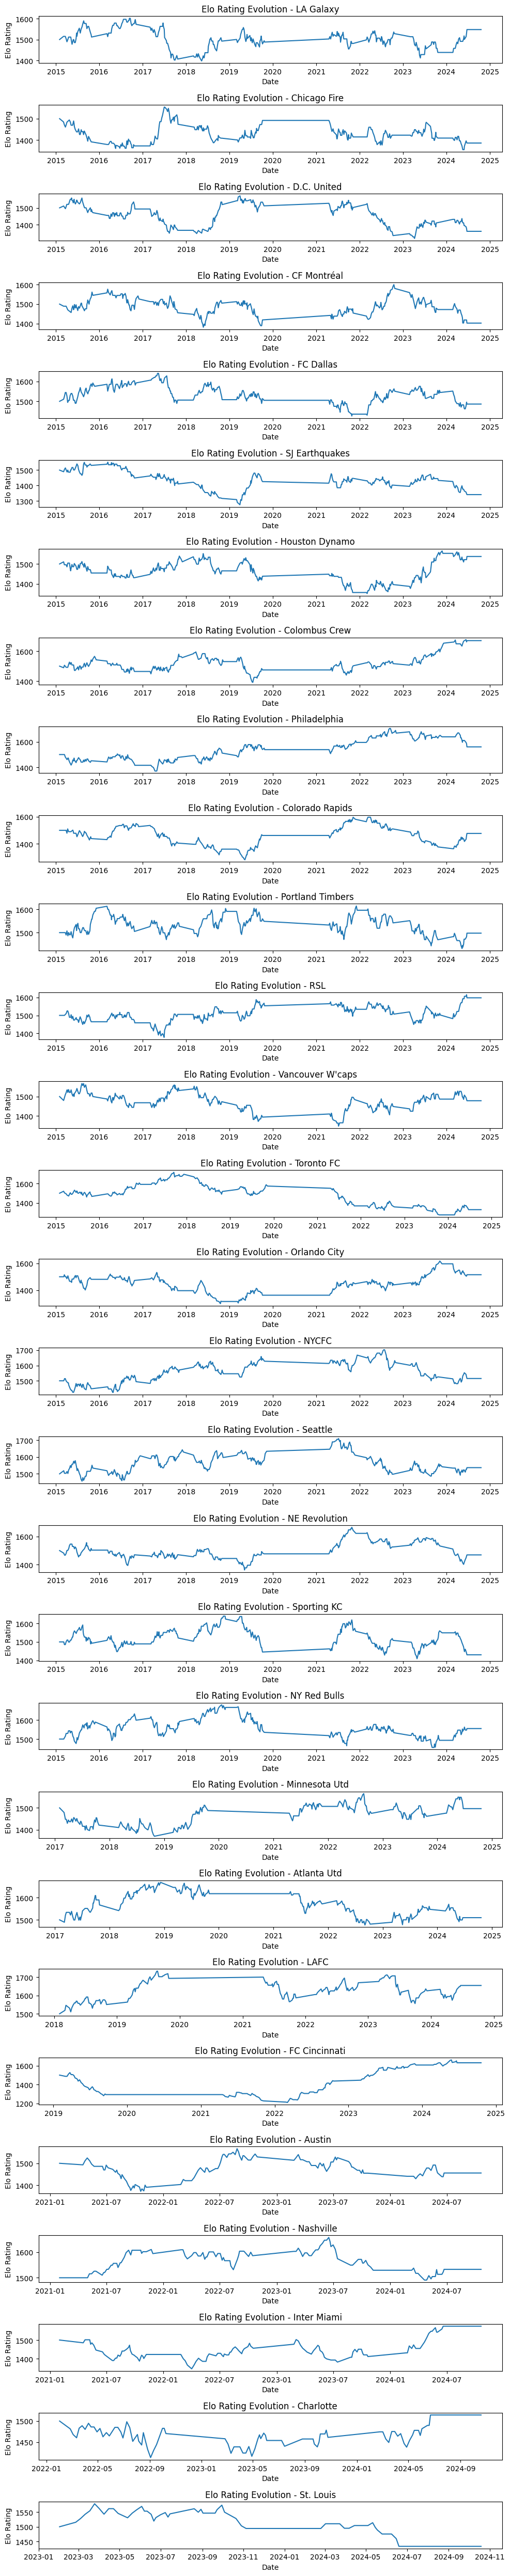

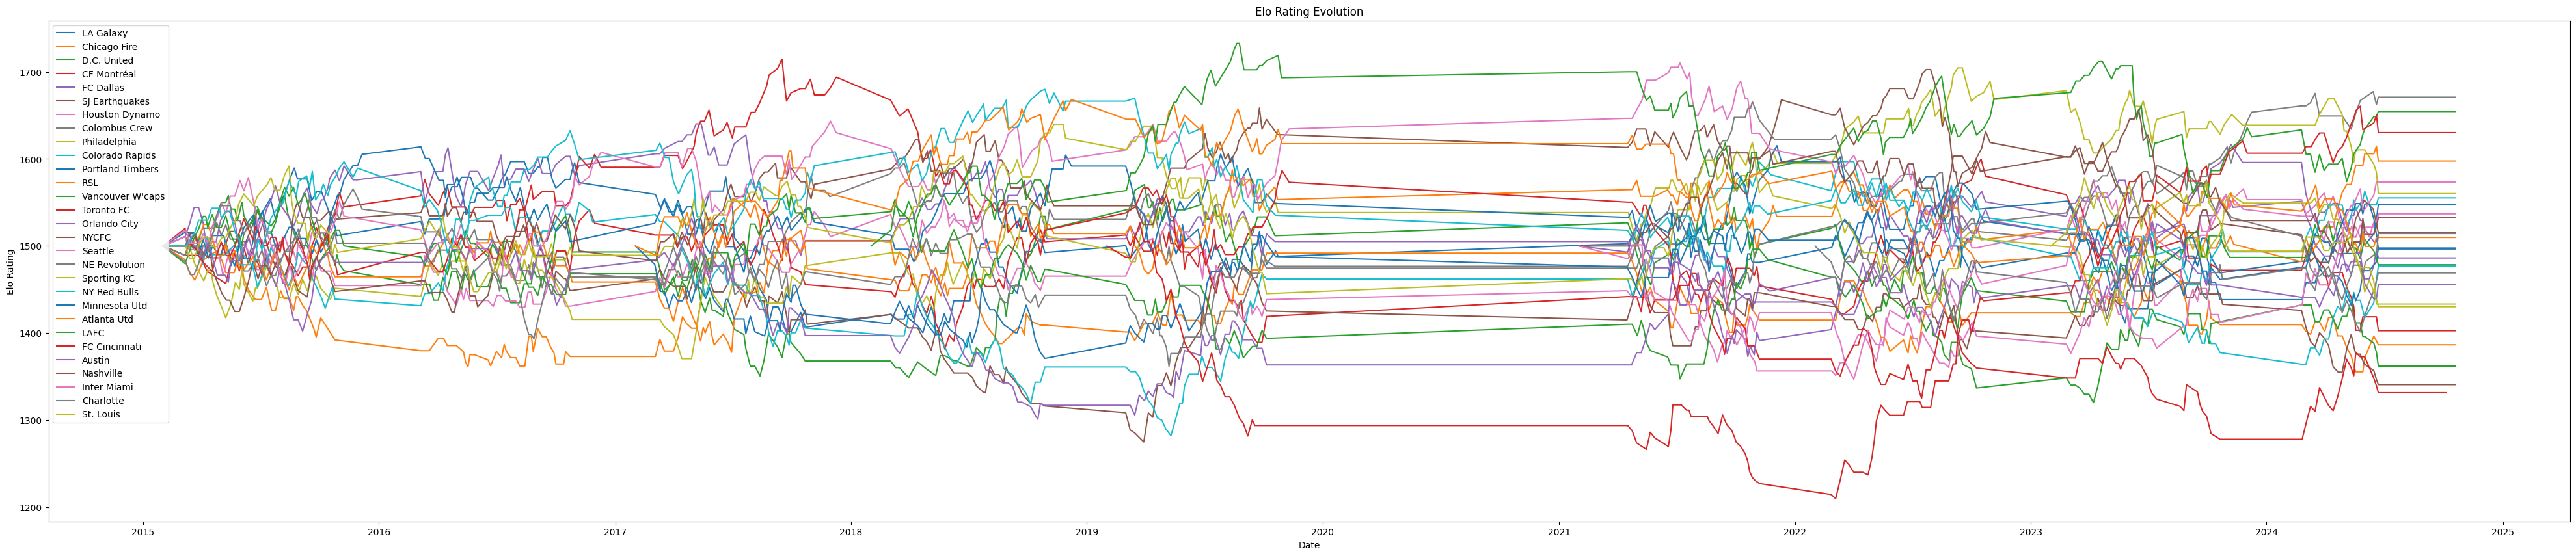

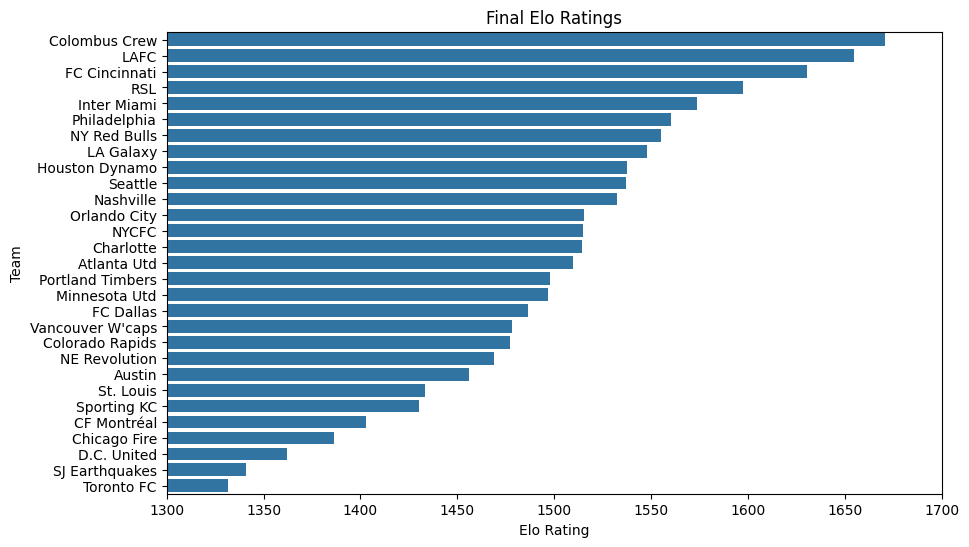

Club       Date   Elo Rating
0     LA Galaxy 2018-03-04  1421.631668
1     LA Galaxy 2018-03-11  1416.057993
2     LA Galaxy 2018-03-24  1416.057993
3     LA Galaxy 2018-03-31  1431.388347
4     LA Galaxy 2018-04-08  1416.162050
...         ...        ...          ...
5610  St. Louis 2024-09-21  1433.329282
5611  St. Louis 2024-09-28  1433.329282
5612  St. Louis 2024-10-02  1433.329282
5613  St. Louis 2024-10-05  1433.329282
5614  St. Louis 2024-10-19  1433.329282

[5615 rows x 3 columns]

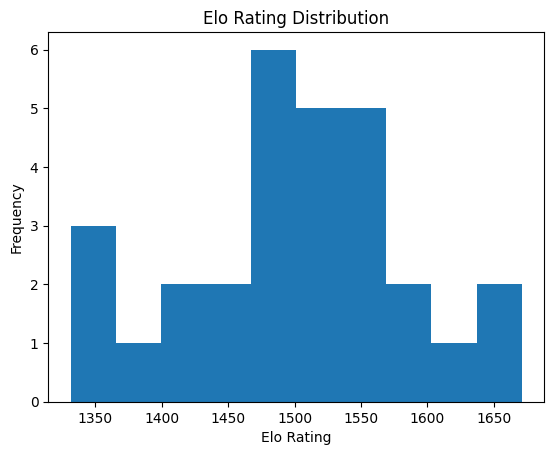

In [4]:
elo_ratings = {}  # Step 1 - Initialize dictionary to store Elo ratings

# Step 2 - Iterate over each match in the schedule
for _, match in mls_schedule_fbref.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_goals = match['home_goals']
    away_goals = match['away_goals']
    date = match['date']

    if home_team not in elo_ratings:  # Step 4 - Initialize Elo ratings for new clubs
        elo_ratings[home_team] = Club(home_team, 1500, pd.Timestamp(f'{date.year}-02-01'))
    if away_team not in elo_ratings:
        elo_ratings[away_team] = Club(away_team, 1500, pd.Timestamp(f'{date.year}-02-01'))

    current_match = Match(elo_ratings[home_team], elo_ratings[away_team], home_goals, away_goals, date)
    current_match.calculate_elo_ratings(HFA=50)
    
    # Step 2.1 - Update Elo ratings for each club
    elo_ratings[home_team].update_elo_rating(current_match.home_club.elo_rating, date)
    elo_ratings[away_team].update_elo_rating(current_match.away_club.elo_rating, date)

# Step 3 - Plot Elo rating evolution for each club in each canvas
fig, axs = plt.subplots(len(elo_ratings.items()), 1, figsize=(10, 50))
for i, (team, club) in enumerate(elo_ratings.items()):
    axs[i].plot(list(club.history.keys()), list(club.history.values()))
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Elo Rating')
    axs[i].set_title(f'Elo Rating Evolution - {team}')
plt.tight_layout()
# plt.show()

# Step 3 - Plot Elo rating evolution for each club in a single canvas
fig, ax = plt.subplots(figsize=(50, 10))
for team, club in elo_ratings.items():
    ax.plot(list(club.history.keys()), list(club.history.values()), label=team)
ax.set_xlabel('Date')
ax.set_ylabel('Elo Rating')
ax.set_title('Elo Rating Evolution')
ax.legend()
# plt.show()


# Step 4 - Print final Elo ratings sorted by elo
sorted_elo_ratings = sorted(elo_ratings.items(), key=lambda x: x[1].elo_rating, reverse=True)
#for team, club in sorted_elo_ratings:
#    print(f'{team}: {club.elo_rating}')

# Step 5 - Visualize final Elo ratings
teams = [team for team, _ in sorted_elo_ratings]
ratings = [club.elo_rating for _, club in sorted_elo_ratings]

plt.figure(figsize=(10, 6))
sns.barplot(x=ratings, y=teams)
plt.xlabel('Elo Rating')
plt.xlim(1300, 1700)
plt.ylabel('Team')
plt.title('Final Elo Ratings')
plt.show()


# Step 6 Histogram of Elo ratings
elo_ratings_values = [club.elo_rating for club in elo_ratings.values()]
plt.hist(elo_ratings_values, bins=10)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution')
# plt.show()

# Step 7 - Export Elo rating evolution to CSV from 2019
elo_history = []
for club in elo_ratings.values():
    for date, ratings in club.history.items():
        if date.year >= 2018:
            elo_history.append({'Club': club.name, 'Date': date, 'Elo Rating': ratings})
elo_history = pd.DataFrame(elo_history)
elo_history.to_csv('mls_elo_history.csv', index=False)
elo_history

## Building our dataset

In [5]:
final_df = pd.read_csv("mls_team_stats_complete.csv")

# Changing some names in order to have the same name for the same team in both columns
def normalizeTeamNames(final_df):
    final_df = final_df.drop(columns=['league','xG','xGA'])
    final_df['team'] = final_df['team'].replace('Rapids','Colorado Rapids')
    final_df['team'] = final_df['team'].replace('Crew','Columbus Crew')
    final_df['team'] = final_df['team'].replace('Dynamo FC','Dynamo')
    final_df['team'] = final_df['team'].replace('Fire','Chicago Fire')
    final_df['team'] = final_df['team'].replace('Montreal Impact','CF Montréal')
    final_df['team'] = final_df['team'].replace('Houston Dynamo','Dynamo')
    final_df['opponent'] = final_df['opponent'].replace('Rapids','Colorado Rapids')
    final_df['opponent'] = final_df['opponent'].replace('Crew','Columbus Crew')
    final_df['opponent'] = final_df['opponent'].replace('Dynamo FC','Dynamo')
    final_df['opponent'] = final_df['opponent'].replace('Fire','Chicago Fire')
    final_df['opponent'] = final_df['opponent'].replace('Montreal Impact','CF Montréal')
    final_df['opponent'] = final_df['opponent'].replace('Houston Dynamo','Dynamo')
    return final_df

final_df = normalizeTeamNames(final_df)

def convert_goals_to_numeric(final_df):
    final_df['GF'] = final_df['GF'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
    final_df['GF'] = pd.to_numeric(final_df['GF'])
    final_df['GA'] = final_df['GA'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
    final_df['GA'] = pd.to_numeric(final_df['GA'])

convert_goals_to_numeric(final_df)


final_df = final_df.sort_values(by=["date","time","game"])
final_df = final_df.drop(columns=["game","('Receiving', 'Rec')","('Receiving', 'PrgR')"])
final_df = final_df.dropna() 

def calculateCompletionRate(final_df):
    final_df["(\'Total\', \'Cmp\')"] = final_df['(\'Total\', \'Cmp\')']/final_df['(\'Total\', \'Att\')']*100
    final_df["(\'Short\', \'Cmp\')"] = final_df['(\'Short\', \'Cmp\')']/final_df['(\'Short\', \'Att\')']*100
    final_df["(\'Medium\', \'Cmp\')"] = final_df['(\'Medium\', \'Cmp\')']/final_df['(\'Medium\', \'Att\')']*100
    final_df["(\'Long\', \'Cmp\')"] = final_df['(\'Long\', \'Cmp\')']/final_df['(\'Long\', \'Att\')']*100

calculateCompletionRate(final_df) 
 
def adjust_season_year(final_df):
    final_df["season"] = final_df["date"].str[:4].astype(int)
    final_df["season"] = final_df["season"] - 2018

adjust_season_year(final_df)

def cleanFormationData(final_df):
    final_df['Formation'] = final_df['Formation'].str.replace('-',' ')
    final_df['Formation'] = final_df['Formation'].str.findall(r'\d+')
    final_df['Defenders'] = final_df['Formation'].apply(lambda x: x[0])
    final_df['Forwards'] = final_df['Formation'].apply(lambda x: x[-1])
    final_df['Midfielders'] = 10 - final_df['Defenders'].astype(int) - final_df['Forwards'].astype(int)
    final_df = final_df.drop(columns=['Formation'])
    return final_df

final_df = cleanFormationData(final_df)

final_df['key_1'] = final_df.apply(lambda row: ''.join([row['team'], row['opponent']]) + row['date'] + row['time'] + str(row['GF'] + row['GA']), axis=1)
final_df['key_2'] = final_df.apply(lambda row: ''.join([row['opponent'], row['team']]) + row['date'] + row['time'] + str(row['GF'] + row['GA']), axis=1)
final_df["antigay_key"] = final_df.apply(lambda row: ''.join(sorted([row['team'], row['opponent']])) + row['date'] + row['time'], axis=1)

def get_previous_elo(row, column_name):
    team = elo_ratings.get(row[column_name])
    if team is not None:
        return team.get_previous_elo_rating(row['date'])
    
final_df['date'] = pd.to_datetime(final_df['date'])
final_df["elo"] = final_df.apply(lambda row: get_previous_elo(row, 'team'), axis=1)

def calculate_average_stats_last_x_matches(final_df, x=10):
    avg_last_x_stats_list = ["Poss","GF","GA","('Performance', 'SoTA')","('Performance', 'Saves')","('Standard', 'Sh')","('Standard', 'SoT')","('Standard', 'Dist')","('Total', 'Cmp')","('Total', 'Att')","('Short', 'Cmp')","('Short', 'Att')","('Medium', 'Cmp')","('Medium', 'Att')","('Long', 'Cmp')","('Long', 'Att')","('Ast', '')","('KP', '')","('1/3', '')","('PPA', '')","('CrsPA', '')","('PrgP', '')","('Pass Types', 'Crs')","('Pass Types', 'TI')","('Pass Types', 'CK')","('SCA Types', 'SCA')","('GCA Types', 'GCA')","('Tackles', 'Tkl')","('Tackles', 'TklW')","('Tackles', 'Def 3rd')","('Tackles', 'Mid 3rd')","('Tackles', 'Att 3rd')","('Blocks', 'Blocks')","('Int', '')","('Clr', '')","('Err', '')","('Touches', 'Touches')","('Touches', 'Def Pen')","('Touches', 'Def 3rd')","('Touches', 'Mid 3rd')","('Touches', 'Att 3rd')","('Touches', 'Att Pen')","('Carries', 'Carries')","('Carries', 'TotDist')","('Carries', 'PrgDist')","('Carries', 'PrgC')","('Carries', '1/3')","('Carries', 'CPA')","('Carries', 'Mis')","('Carries', 'Dis')","('Aerial Duels', 'Won')","('Aerial Duels', 'Lost')","('Performance', 'CrdY')","('Performance', 'CrdR')","('Performance', 'Fls')","('Performance', 'Fld')"]
    avg_last_x_stats = []
    indices_to_keep = []
    for index, row in final_df.iterrows():
        team_stats_last_x_matches = final_df.loc[(final_df['team'] == row['team']) & (final_df['date'] < row['date'])].sort_values(by=['date'], ascending=False).head(x)
        if len(team_stats_last_x_matches) == x:
            avg_stats = team_stats_last_x_matches[avg_last_x_stats_list].mean(axis=0).values
            avg_last_x_stats.append(avg_stats)
            indices_to_keep.append(index)
    final_df_filtered = final_df.loc[indices_to_keep]
    avg_last_x_stats_per_team = pd.DataFrame(avg_last_x_stats, columns=[f'average_{stat}_last_x' for stat in avg_last_x_stats_list])
    final_df_with_avg_stats = pd.concat([final_df_filtered.reset_index(drop=True), avg_last_x_stats_per_team], axis=1)
    final_df_with_avg_stats = final_df_with_avg_stats.drop(columns=avg_last_x_stats_list)
    return final_df_with_avg_stats

final_df_with_avg_stats_10 = calculate_average_stats_last_x_matches(final_df, x=10)
final_df_with_avg_stats_5 = calculate_average_stats_last_x_matches(final_df, x=5)
final_df_with_avg_stats_15 = calculate_average_stats_last_x_matches(final_df, x=15)

def prepare_team_data(final_df_with_avg_stats):
    df1 = final_df_with_avg_stats.copy()
    df2 = final_df_with_avg_stats.copy()
    df1.columns = [col + '_team1' for col in df1.columns]
    df2.columns = [col + '_team2' for col in df2.columns]
    merged_df = pd.merge(df1, df2, left_on='key_1_team1', right_on='key_2_team2')
    merged_df.drop_duplicates(subset=["antigay_key_team1", "antigay_key_team2"], inplace=True)
    merged_df.drop(columns=['key_1_team1','key_2_team2',"key_1_team2","key_2_team1","season_team2","opponent_team1","opponent_team2","result_team2","season_team2","team_team1","team_team2","date_team1","date_team2","time_team2","time_team1","antigay_key_team1", "antigay_key_team2"], inplace=True)
    return merged_df

merged_df_10 = prepare_team_data(final_df_with_avg_stats_10)
merged_df_5 = prepare_team_data(final_df_with_avg_stats_5)
merged_df_15 = prepare_team_data(final_df_with_avg_stats_15)

final_df_with_avg_stats_5.drop(columns=['key_1',"key_2"], inplace=True)
final_df_with_avg_stats_10.drop(columns=['key_1',"key_2"], inplace=True)
final_df_with_avg_stats_15.drop(columns=['key_1',"key_2"], inplace=True)

# merged_df.head(10)
#final_df.tail(20)
#final_df.head()
#printami tutti i nomi delle colonne attraverso un ciclo for

print(merged_df_5.shape)
print(merged_df_10.shape)
print(merged_df_15.shape)

(1494, 122)
(1416, 122)
(1338, 122)


## Data Exploration


In [38]:
# Correlation matrix
corr = final_df_with_avg_stats_15.drop(columns=["team","opponent","date","time","result","antigay_key"]).corr()
plt.figure(figsize=(100, 100))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

/var/folders/ml/gl5hlvz1671_46k_bk_zwqlh0000gn/T/ipykernel_8092/1998795050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Win"]=filtered_df["GF"]>filtered_df["GA"]
/var/folders/ml/gl5hlvz1671_46k_bk_zwqlh0000gn/T/ipykernel_8092/1998795050.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Draw"]=filtered_df["GF"]==filtered_df["GA"]
/var/folders/ml/gl5hlvz1671_46k_bk_zwqlh0000gn/T/ipykernel_8092/1998795050.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

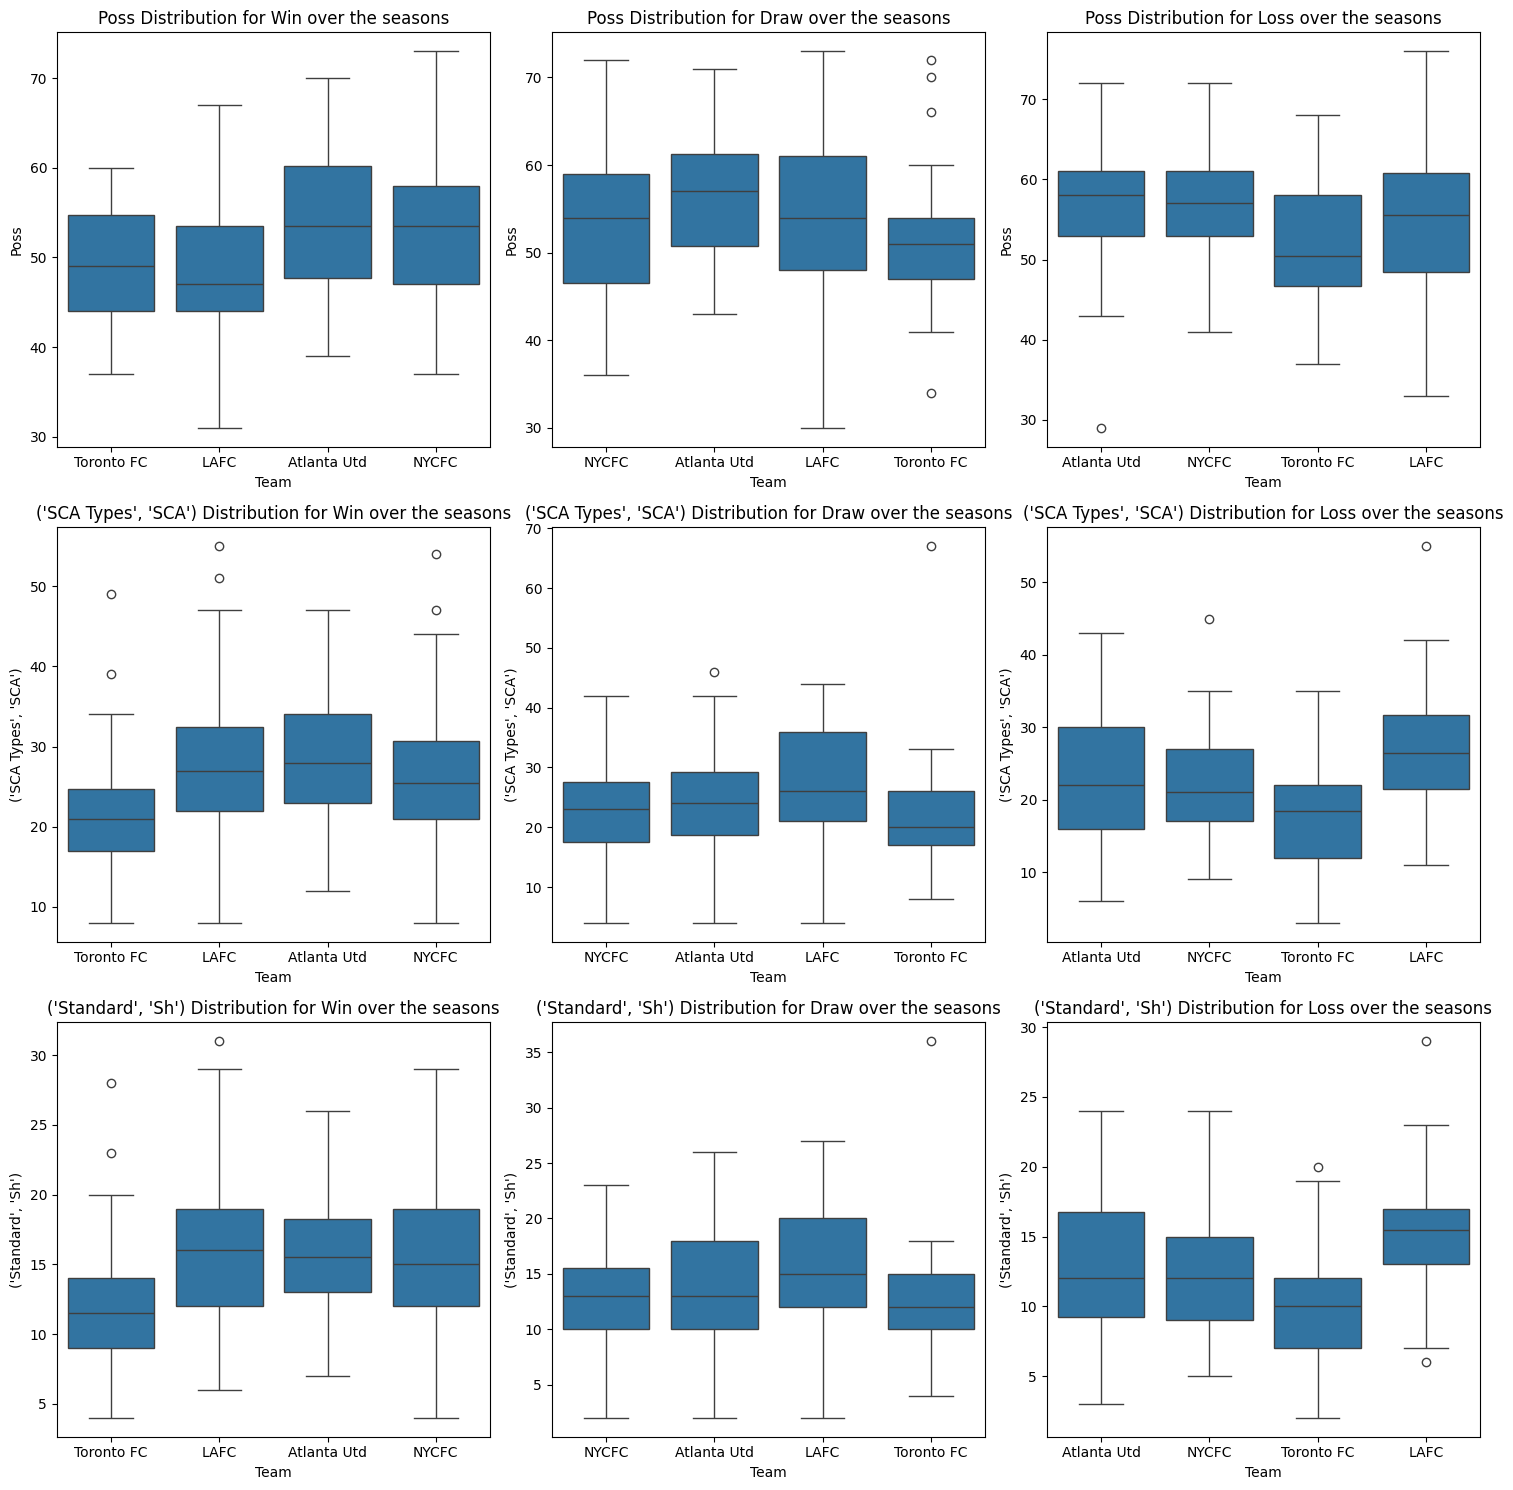

In [7]:
# Define the teams of interest
teams = ['LAFC', 'Atlanta Utd', 'NYCFC','Toronto FC']

# Filter the DataFrame for the specified season and teams
filtered_df = final_df[(final_df['team'].isin(teams))]

filtered_df["Win"]=filtered_df["GF"]>filtered_df["GA"]
filtered_df["Draw"]=filtered_df["GF"]==filtered_df["GA"]
filtered_df["Loss"]=filtered_df["GF"]<filtered_df["GA"]
filtered_df = filtered_df.drop(columns=["result"])

# Select the features of interest
features = ["Poss", "('SCA Types', 'SCA')","('Standard', 'Sh')"]

# Definisci le colonne di risultato
results = ['Win', 'Draw', 'Loss']

# Imposta il numero di subplot basato sul numero di caratteristiche e risultati
fig, axes = plt.subplots(nrows=len(features), ncols=len(results), figsize=(15, 5 * len(features)))

# Cicla attraverso le caratteristiche e i risultati e crea un boxplot per ciascuno
for i, feature in enumerate(features):
    for j, result in enumerate(results):
        ax = axes[i][j]
        sns.boxplot(x='team', y=feature, data=filtered_df[filtered_df[result] == 1], ax=ax)
        ax.set_title(f'{feature} Distribution for {result} over the seasons')
        ax.set_xlabel('Team')
        ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


## Building ML model

In [40]:
import time
import multiprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import DataConversionWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [48]:
# Print the available CPUs
num_cpus = multiprocessing.cpu_count()
print(num_cpus)

# Ignore some warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)


##############################
## RANFOM FOREST CLASSIFIER ##
##############################

def run_RFC(X_train, X_test, y_train, y_test):

    name='Random Forest Classifier'
    
    # Initialize RFC model using a fixed random state and activating out of bag tree errors
    model_RFC = RandomForestClassifier(oob_score=True, random_state=2001)

    # Define a range of values for n estimators and max depth of the trees
    param_grid_RFC = {'n_estimators': [25, 50, 75, 100, 250, 500, 750, 1000],
                  'max_features': [None, 'sqrt', 'log2'],
                  'max_depth': [None, 1, 5, 10, 15, 25, 35, 50]}

    # param_grid_RFC = {'n_estimators': [100, 400], 'max_features': ['sqrt', 'log2'], 'max_depth': [5, 10]}

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5)

    # Create a grid search object
    grid_search_RFC = GridSearchCV(model_RFC, param_grid_RFC, cv=skf, scoring='accuracy', n_jobs=-1)

    # Fit the grid search to the training data
    grid_search_RFC.fit(X_train, y_train)

    # Print the best parameters and score
    print('Best parameters:', grid_search_RFC.best_params_)
    print('Best score:', grid_search_RFC.best_score_)

    # Get the best model
    best_model_RFC = grid_search_RFC.best_estimator_

    # Make predictions on the testing data
    y_pred_RFC = best_model_RFC.predict(X_test)

    # Evaluate the performance using accuracy
    accuracy_RFC = accuracy_score(y_test, y_pred_RFC)
    print('Accuracy on the testing data:', accuracy_RFC)

    # Plot the confusion matrix
    plot_conf_mat(y_test, y_pred_RFC, name=name)

    # Generate the classification report
    print(classification_report(y_test, y_pred_RFC, zero_division = 0))

    # Plot learning curve
    learn_curve_plotter(best_model_RFC, X_train, y_train, skf, name=name)

    # Plot feature selection
    feature_selection_finder(best_model_RFC, X_train, y_train, name=name)

###################
## kNN ALGORITHM ##
###################

def knn_model(X_train, X_test, y_train, y_test):
    
    name='k-Nearest Neighbors'
    
    # Create a kNN model
    model_kNN = KNeighborsClassifier()

    # Define a range of values for the hyperparameters
    param_grid_kNN = {'n_neighbors': [1,10,20,30,40,50,60,70,80,90,100],
                      'weights': ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan', 'minkowski'],
                      'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                      'leaf_size': [10, 20, 30, 40, 50]}

    # Create a scaler and fit it to your training data
    scaler_kNN = StandardScaler()
    X_train_scaled_kNN = scaler_kNN.fit_transform(X_train)
    X_test_scaled_kNN = scaler_kNN.transform(X_test)

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5)
    
    # Create a grid search object
    grid_search_kNN = GridSearchCV(model_kNN, param_grid_kNN, cv=skf, scoring='accuracy', n_jobs=-1)

    # Fit the grid search to the scaled training data
    grid_search_kNN.fit(X_train_scaled_kNN, y_train)

    # Print the best parameters and score
    print('Best parameters:', grid_search_kNN.best_params_)
    print('Best score:', grid_search_kNN.best_score_)

    # Get the best model
    best_model_kNN = grid_search_kNN.best_estimator_

    # Make predictions on the scaled testing data
    y_pred_kNN = best_model_kNN.predict(X_test_scaled_kNN)

    # Evaluate the performance using accuracy
    accuracy_kNN = accuracy_score(y_test, y_pred_kNN)
    print('Accuracy on the testing data:', accuracy_kNN)

    # Plot the confusion matrix
    plot_conf_mat(y_test, y_pred_kNN, name=name)

    # Generate the classification report
    print(classification_report(y_test, y_pred_kNN, zero_division = 0))

    # Plot learning curve
    learn_curve_plotter(best_model_kNN, X_train_scaled_kNN, y_train, skf, name=name)

############################
## NAIVE BAYES - GAUSSIAN ##
############################

def gnb_model(X_train, X_test, y_train, y_test):
    
    name = 'GaussianNB'
    
    # Create a Gaussian Naive Bayes model
    model_GNB = GaussianNB()

    # Create a scaler and fit it to your training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit the model to the scaled training data
    model_GNB.fit(X_train_scaled, y_train)

    # Make predictions on the scaled testing data
    y_pred_GNB = model_GNB.predict(X_test_scaled)

    # Evaluate the performance using accuracy
    accuracy_GNB = accuracy_score(y_test, y_pred_GNB)
    print('Accuracy on the testing data:', accuracy_GNB)

    # Plot the confusion matrix
    plot_conf_mat(y_test, y_pred_GNB, name=name)

    # Generate the classification report
    print(classification_report(y_test, y_pred_GNB, zero_division = 0))

    # Create a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5)

    # Plot the learning curve
    learn_curve_plotter(model_GNB, X_train_scaled, y_train, skf, name=name)
    
####################
## OVERALL RUNNER ##
####################

def run_all_models(X_train, X_test, y_train, y_test):
    
    start_time = time.time()
    print("Running Random Forest Classifier!")
    run_RFC(X_train, X_test, y_train, y_test)
    print("run_RFC took %s seconds" % (time.time() - start_time))
    
    start_time = time.time()
    print("Running k-Nearest Neighbors!")
    knn_model(X_train, X_test, y_train, y_test)
    print("knn_model took %s seconds" % (time.time() - start_time))

    start_time = time.time()
    print("Running Gaussian Naive Bayes!")
    gnb_model(X_train, X_test, y_train, y_test)
    print("gnb_model took %s seconds" % (time.time() - start_time))

############################
## LEARNING CURVE PLOTTER ##
############################

def learn_curve_plotter(best_model, X_train, y_train, skf, name):
    # Generate the learning curves
    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train, y_train, cv=skf, scoring='accuracy')

    # Calculate the mean and standard deviation of the scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)

    # Plot the learning curves
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, val_scores_mean, label='Validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1)
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title('Learning curves for the ' + name)
    plt.legend()
    plt.grid()
    plt.show()

##############################
## CONFUSION MATRIX PLOTTER ##
##############################

def plot_conf_mat(y_test, y_pred, name):
     
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for '+name)
    plt.show()


##############################
## FEATURE SELECTION FINDER ##
##############################

def feature_selection_finder(best_model, X_train, y_train, name):

    # Create a feature selection object
    selector = SelectFromModel(best_model)

    # Fit the selector to the training data
    selector.fit(X_train, y_train)

    # Get the feature importances
    feature_importances = selector.estimator_.feature_importances_

    # Get the indices of the most 25 important features
    indices = np.argsort(feature_importances)[::-1][:20]

    # Print the feature importances
    print('Feature Importances for ' + name)
    for i, idx in enumerate(indices):
        print(f'{i + 1}: {X_train.columns[idx]} - {feature_importances[idx]}')

16


ML models with 15 matches average stats
Accuracy of Dummy Classifier: 0.35447761194029853
(1139, 122)
(199, 122)
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 15 matches average stats
Running Random Forest Classifier!
Best parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
Best score: 0.4152948450421207
Accuracy on the testing data: 0.39195979899497485


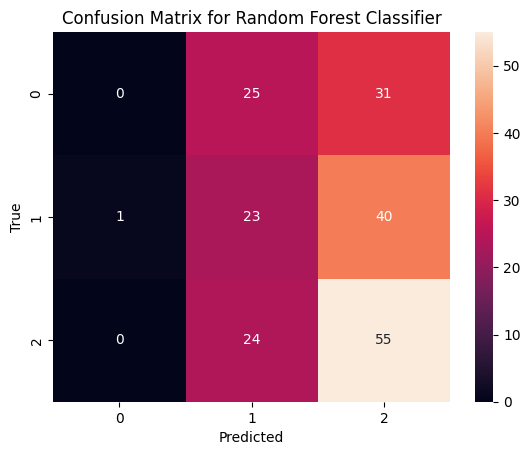

              precision    recall  f1-score   support

           D       0.00      0.00      0.00        56
           L       0.32      0.36      0.34        64
           W       0.44      0.70      0.54        79

    accuracy                           0.39       199
   macro avg       0.25      0.35      0.29       199
weighted avg       0.28      0.39      0.32       199



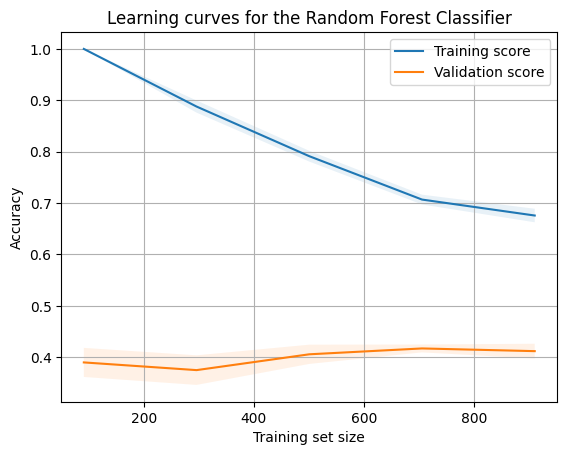

Feature Importances for Random Forest Classifier
1: average_('Carries', 'Mis')_last_x_team2 - 0.02052258834928343
2: average_('Touches', 'Def 3rd')_last_x_team2 - 0.017631137520323456
3: average_GF_last_x_team1 - 0.016960886506900058
4: average_('Medium', 'Cmp')_last_x_team1 - 0.016019892173068432
5: average_('Total', 'Cmp')_last_x_team2 - 0.015726648229807946
6: average_('Short', 'Cmp')_last_x_team2 - 0.015425892963464506
7: average_('PPA', '')_last_x_team2 - 0.015211836849729597
8: average_('Carries', '1/3')_last_x_team2 - 0.01518130037808183
9: average_('Total', 'Att')_last_x_team2 - 0.015006812967431787
10: average_('Blocks', 'Blocks')_last_x_team1 - 0.014272646984411646
11: average_('Standard', 'SoT')_last_x_team2 - 0.013906048237270725
12: average_('Pass Types', 'Crs')_last_x_team2 - 0.013266995442774907
13: average_('Standard', 'Sh')_last_x_team2 - 0.013221963096956571
14: average_('Medium', 'Cmp')_last_x_team2 - 0.013128963427387423
15: average_('PPA', '')_last_x_team1 - 0.0130

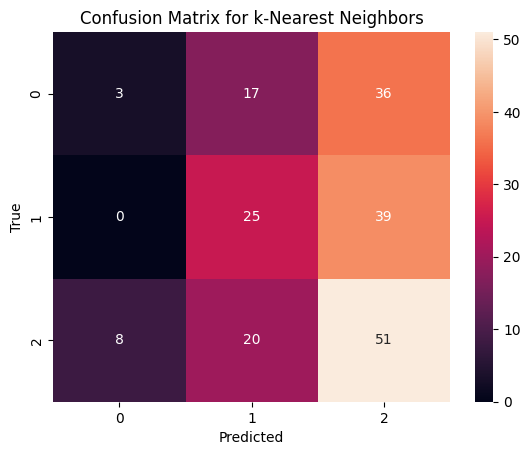

              precision    recall  f1-score   support

           D       0.27      0.05      0.09        56
           L       0.40      0.39      0.40        64
           W       0.40      0.65      0.50        79

    accuracy                           0.40       199
   macro avg       0.36      0.36      0.33       199
weighted avg       0.37      0.40      0.35       199



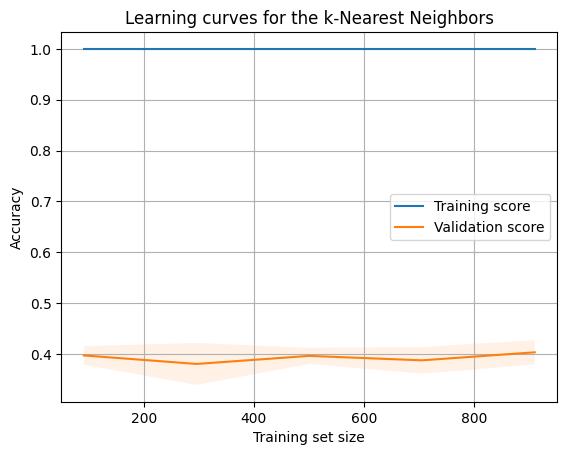

knn_model took 15.215700387954712 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.34673366834170855


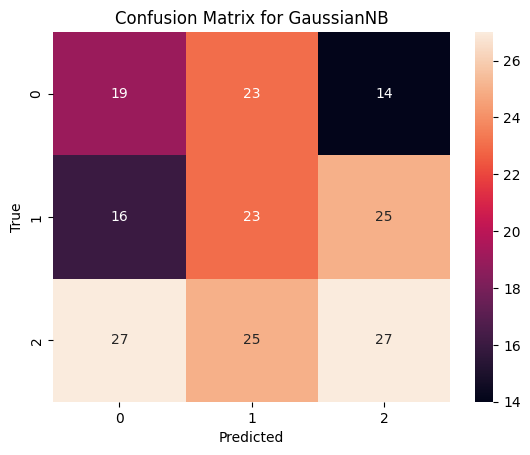

              precision    recall  f1-score   support

           D       0.31      0.34      0.32        56
           L       0.32      0.36      0.34        64
           W       0.41      0.34      0.37        79

    accuracy                           0.35       199
   macro avg       0.35      0.35      0.35       199
weighted avg       0.35      0.35      0.35       199



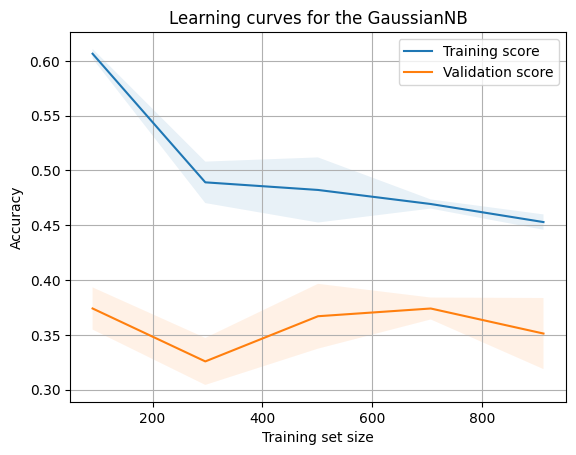

gnb_model took 0.2681710720062256 seconds
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 15 matches average stats, but only the most important
Running Random Forest Classifier!
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000}
Best score: 0.4240242677177525
Accuracy on the testing data: 0.5794556628621598


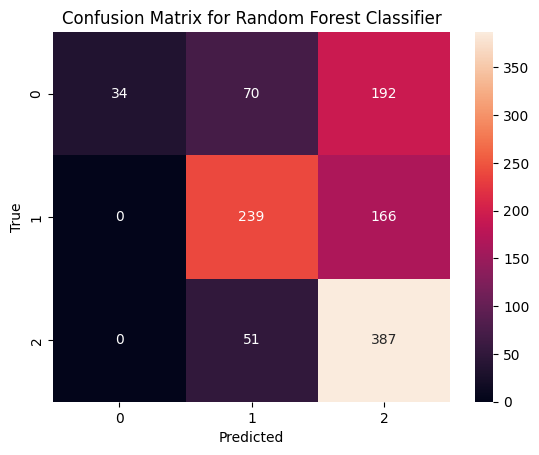

              precision    recall  f1-score   support

           D       1.00      0.11      0.21       296
           L       0.66      0.59      0.62       405
           W       0.52      0.88      0.65       438

    accuracy                           0.58      1139
   macro avg       0.73      0.53      0.50      1139
weighted avg       0.70      0.58      0.53      1139



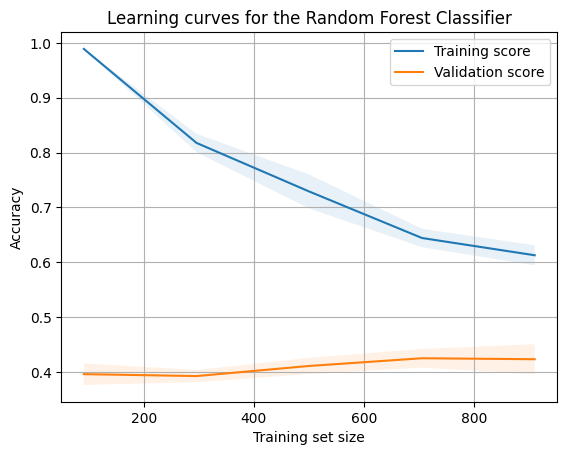

Feature Importances for Random Forest Classifier
1: average_('SCA Types', 'SCA')_last_x_team2 - 0.09499321289011745
2: elo_team2 - 0.09050678997421613
3: average_('Standard', 'Sh')_last_x_team2 - 0.08441092832612737
4: average_Poss_last_x_team2 - 0.06967478938198347
5: average_GF_last_x_team1 - 0.06863738764426257
6: average_('SCA Types', 'SCA')_last_x_team1 - 0.0633045610084981
7: elo_team1 - 0.06276137659352958
8: average_Poss_last_x_team1 - 0.06171155849495157
9: average_('Standard', 'Sh')_last_x_team1 - 0.06084551958116238
10: average_('GCA Types', 'GCA')_last_x_team1 - 0.060351059101533544
11: average_('GCA Types', 'GCA')_last_x_team2 - 0.05167886673318609
12: average_GF_last_x_team2 - 0.05023548441801862
13: average_GA_last_x_team2 - 0.0440083241349809
14: average_GA_last_x_team1 - 0.040887382834783485
15: Defenders_team2 - 0.021427275168537704
16: season_team1 - 0.01740047416393253
17: Midfielders_team2 - 0.01571196787162768
18: Forwards_team2 - 0.012629123605040513
19: Midfield

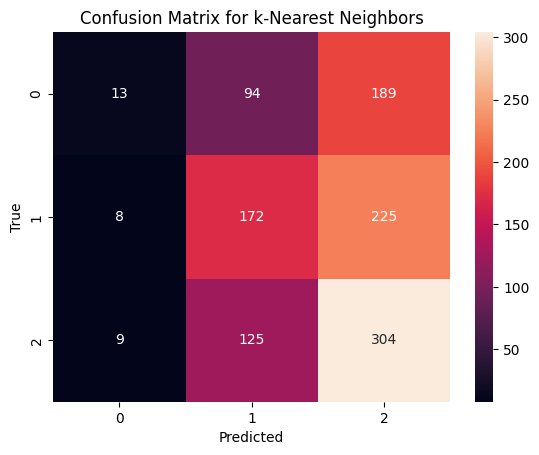

              precision    recall  f1-score   support

           D       0.43      0.04      0.08       296
           L       0.44      0.42      0.43       405
           W       0.42      0.69      0.53       438

    accuracy                           0.43      1139
   macro avg       0.43      0.39      0.35      1139
weighted avg       0.43      0.43      0.38      1139



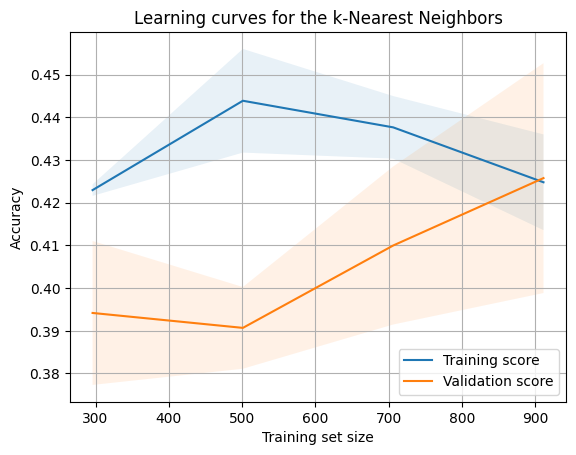

knn_model took 6.701962947845459 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.4240561896400351


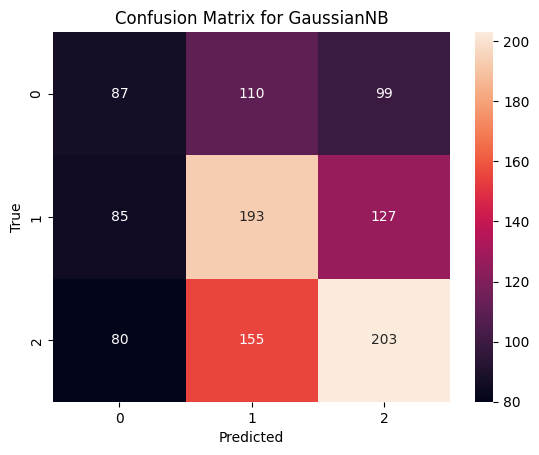

              precision    recall  f1-score   support

           D       0.35      0.29      0.32       296
           L       0.42      0.48      0.45       405
           W       0.47      0.46      0.47       438

    accuracy                           0.42      1139
   macro avg       0.41      0.41      0.41      1139
weighted avg       0.42      0.42      0.42      1139



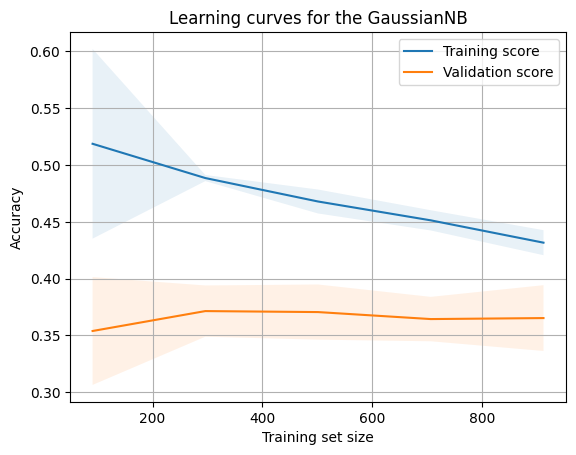

gnb_model took 0.24629807472229004 seconds


In [49]:
# Let's start with 15 matches average stats

print("ML models with 15 matches average stats")

# Dummy Classifier

# Assuming X and y are defined
x_dummy  = merged_df_15.drop(columns=['result_team1'])
y_dummy = merged_df_15[['result_team1']]

# Split the data into training and test sets
x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy, y_dummy, test_size=0.2, random_state=42)

# Initialize the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier to the training data
dummy_clf.fit(x_train_dummy, y_train_dummy)

# Make predictions on the test data
y_pred = dummy_clf.predict(x_test_dummy)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_dummy, y_pred)
print(f'Accuracy of Dummy Classifier: {accuracy}')


# Train/Test Split with date based split

train_data_15 = merged_df_15[merged_df_15['season_team1'] < 6]
test_data_15 = merged_df_15[merged_df_15['season_team1'] == 6]

#train_data = train_data.drop(columns=['season_team1'])
#test_data = test_data.drop(columns=['season_team1'])

print(train_data_15.shape)
print(test_data_15.shape)

X_train = train_data_15.drop(columns=['result_team1'])
X_test = test_data_15.drop(columns=['result_team1'])
Y_train = train_data_15['result_team1']
Y_test = test_data_15['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 15 matches average stats")
run_all_models(X_train, X_test, Y_train, Y_test)

# What if we use less average stats, only the most important?

train_data_15 = train_data_15[["season_team1","result_team1", "Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]
test_data_15 = train_data_15[["season_team1","result_team1","Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]

X_train = train_data_15.drop(columns=['result_team1'])
X_test = test_data_15.drop(columns=['result_team1'])
Y_train = train_data_15['result_team1']
Y_test = test_data_15['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 15 matches average stats, but only the most important")
run_all_models(X_train, X_test, Y_train, Y_test)

# Il modello sopra ha 22 colonne

ML models with 10 matches average stats
Accuracy of Dummy Classifier: 0.40492957746478875
(1217, 122)
(121, 122)
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 10 matches average stats
Running Random Forest Classifier!
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
Best score: 0.4174155029346286
Accuracy on the testing data: 0.39669421487603307


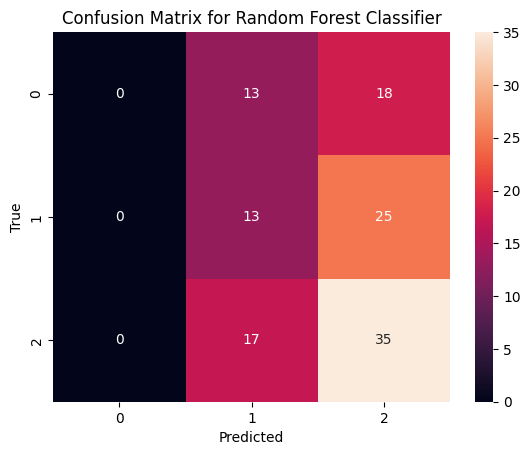

              precision    recall  f1-score   support

           D       0.00      0.00      0.00        31
           L       0.30      0.34      0.32        38
           W       0.45      0.67      0.54        52

    accuracy                           0.40       121
   macro avg       0.25      0.34      0.29       121
weighted avg       0.29      0.40      0.33       121



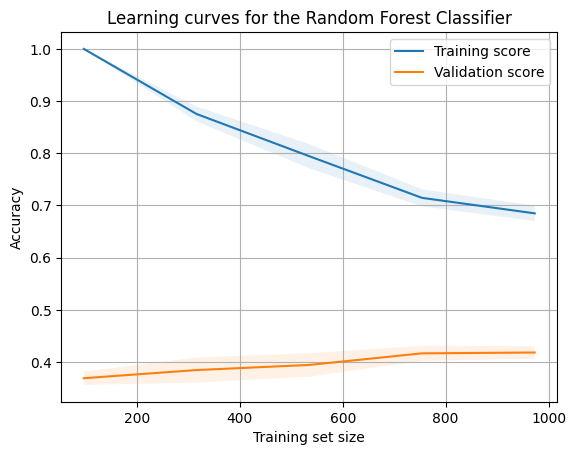

Feature Importances for Random Forest Classifier
1: average_GF_last_x_team1 - 0.029276073060573716
2: average_('SCA Types', 'SCA')_last_x_team2 - 0.028193997661396474
3: average_('Touches', 'Def 3rd')_last_x_team2 - 0.022028519685465788
4: average_('Standard', 'Sh')_last_x_team2 - 0.0209160137064182
5: elo_team2 - 0.01993340924991987
6: average_('Touches', 'Mid 3rd')_last_x_team1 - 0.017252204352816766
7: average_('Standard', 'SoT')_last_x_team1 - 0.01638087805130957
8: average_('Carries', '1/3')_last_x_team2 - 0.01592040410082928
9: average_('Standard', 'SoT')_last_x_team2 - 0.015801527686793805
10: average_('Performance', 'Fls')_last_x_team2 - 0.01574929000236554
11: average_('Long', 'Att')_last_x_team2 - 0.015296885479157418
12: average_('GCA Types', 'GCA')_last_x_team1 - 0.015223819188078136
13: average_('Medium', 'Cmp')_last_x_team2 - 0.015142547657588244
14: average_('PPA', '')_last_x_team1 - 0.014587169770208915
15: average_('PrgP', '')_last_x_team2 - 0.014170290357716624
16: av

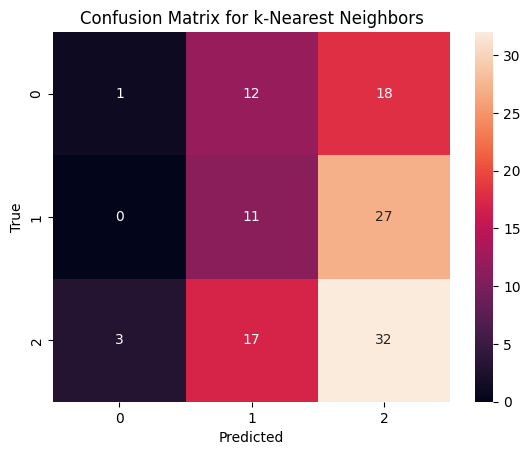

              precision    recall  f1-score   support

           D       0.25      0.03      0.06        31
           L       0.28      0.29      0.28        38
           W       0.42      0.62      0.50        52

    accuracy                           0.36       121
   macro avg       0.31      0.31      0.28       121
weighted avg       0.33      0.36      0.32       121



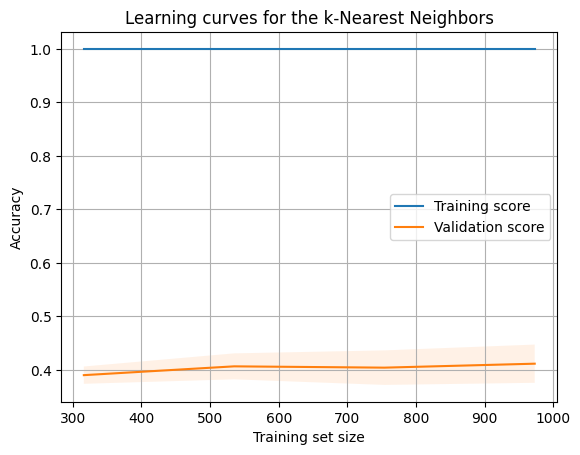

knn_model took 17.116839170455933 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.36363636363636365


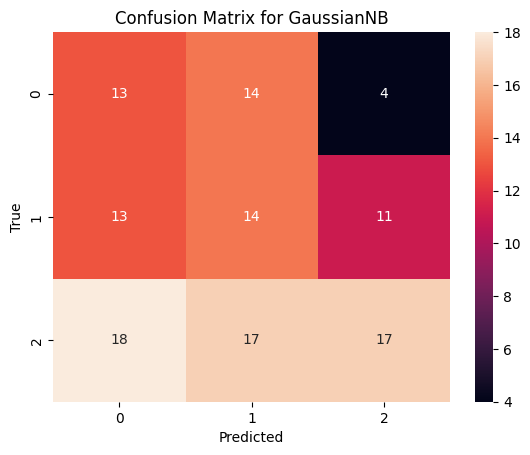

              precision    recall  f1-score   support

           D       0.30      0.42      0.35        31
           L       0.31      0.37      0.34        38
           W       0.53      0.33      0.40        52

    accuracy                           0.36       121
   macro avg       0.38      0.37      0.36       121
weighted avg       0.40      0.36      0.37       121



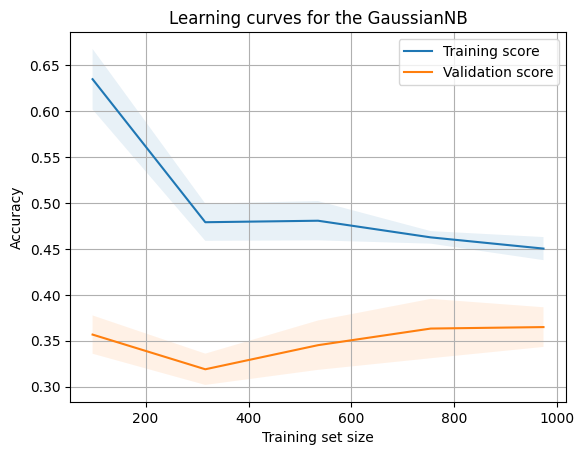

gnb_model took 0.28520965576171875 seconds
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 10 matches average stats, but only the most important
Running Random Forest Classifier!
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Best score: 0.41990825069149296
Accuracy on the testing data: 0.5636811832374692


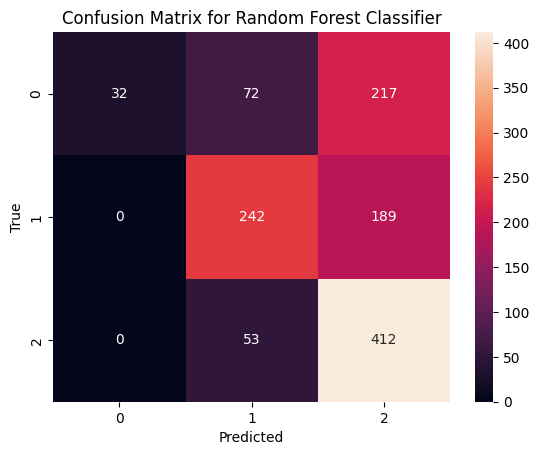

              precision    recall  f1-score   support

           D       1.00      0.10      0.18       321
           L       0.66      0.56      0.61       431
           W       0.50      0.89      0.64       465

    accuracy                           0.56      1217
   macro avg       0.72      0.52      0.48      1217
weighted avg       0.69      0.56      0.51      1217



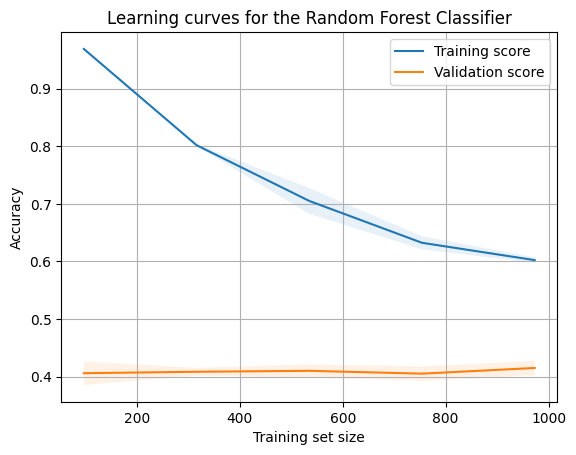

Feature Importances for Random Forest Classifier
1: average_('Standard', 'Sh')_last_x_team2 - 0.08469367423766877
2: average_('SCA Types', 'SCA')_last_x_team2 - 0.08348164276878774
3: elo_team2 - 0.0830607082030963
4: average_Poss_last_x_team2 - 0.07243911667949088
5: elo_team1 - 0.07162020476527207
6: average_GF_last_x_team1 - 0.06988675194723415
7: average_('GCA Types', 'GCA')_last_x_team1 - 0.06709354076480589
8: average_('Standard', 'Sh')_last_x_team1 - 0.06505820580648641
9: average_('SCA Types', 'SCA')_last_x_team1 - 0.06272273302890101
10: average_Poss_last_x_team1 - 0.06227295735219586
11: average_('GCA Types', 'GCA')_last_x_team2 - 0.05750248839177314
12: average_GF_last_x_team2 - 0.05050609900719704
13: average_GA_last_x_team1 - 0.04078833098577025
14: average_GA_last_x_team2 - 0.03321054184366189
15: season_team1 - 0.021860392940976813
16: Defenders_team2 - 0.02121388830224131
17: Midfielders_team2 - 0.016101283949169754
18: Forwards_team2 - 0.011597967894795568
19: Forwards

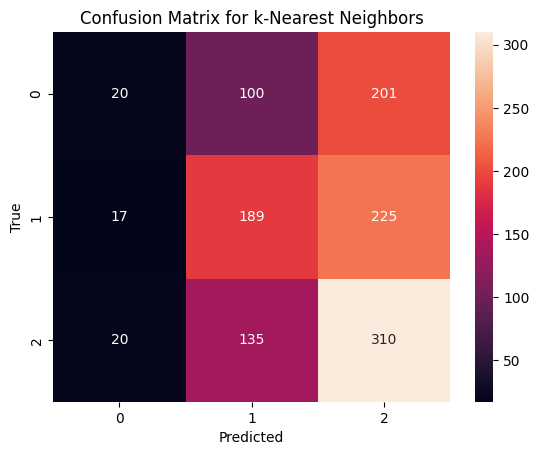

              precision    recall  f1-score   support

           D       0.35      0.06      0.11       321
           L       0.45      0.44      0.44       431
           W       0.42      0.67      0.52       465

    accuracy                           0.43      1217
   macro avg       0.41      0.39      0.35      1217
weighted avg       0.41      0.43      0.38      1217



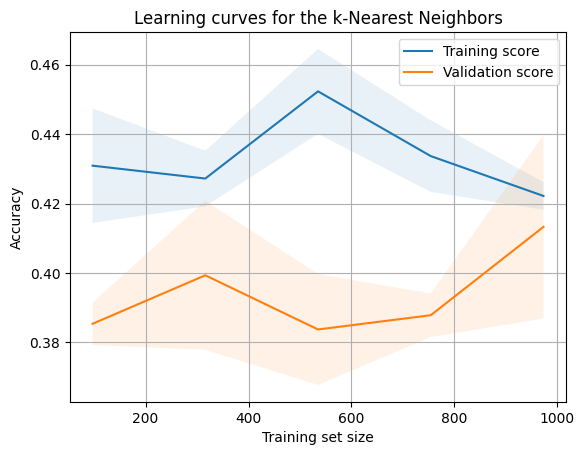

knn_model took 7.115569829940796 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.42152834839769926


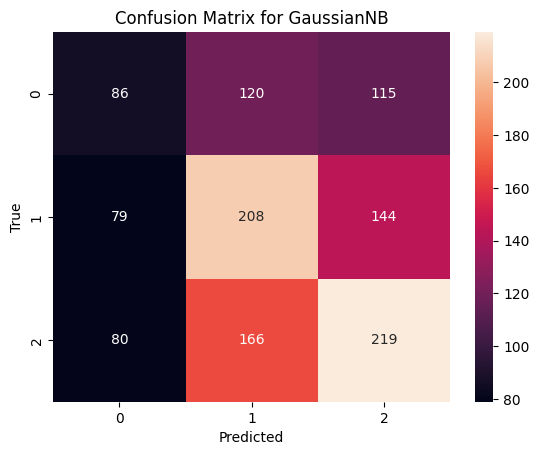

              precision    recall  f1-score   support

           D       0.35      0.27      0.30       321
           L       0.42      0.48      0.45       431
           W       0.46      0.47      0.46       465

    accuracy                           0.42      1217
   macro avg       0.41      0.41      0.41      1217
weighted avg       0.42      0.42      0.42      1217



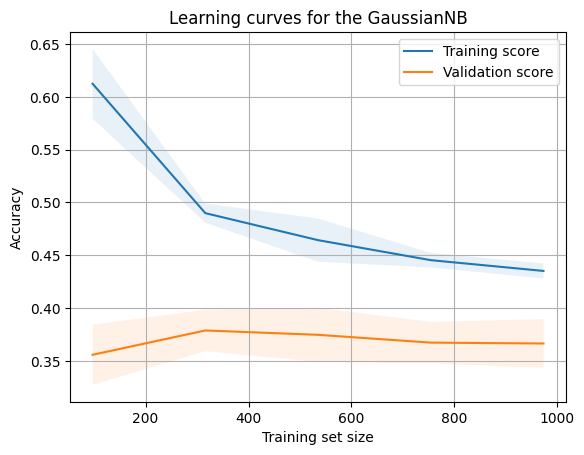

gnb_model took 0.2632887363433838 seconds


In [50]:
# Let's try now with 10 matches average stats

print("ML models with 10 matches average stats")

# Dummy Classifier

# Assuming X and y are defined
x_dummy  = merged_df_10.drop(columns=['result_team1'])
y_dummy = merged_df_10[['result_team1']]

# Split the data into training and test sets
x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy, y_dummy, test_size=0.2, random_state=42)

# Initialize the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier to the training data
dummy_clf.fit(x_train_dummy, y_train_dummy)

# Make predictions on the test data
y_pred = dummy_clf.predict(x_test_dummy)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_dummy, y_pred)
print(f'Accuracy of Dummy Classifier: {accuracy}')


# Train/Test Split with date based split

train_data_10 = merged_df_15[merged_df_10['season_team1'] < 6]
test_data_10 = merged_df_15[merged_df_10['season_team1'] == 6]

#train_data = train_data.drop(columns=['season_team1'])
#test_data = test_data.drop(columns=['season_team1'])

print(train_data_10.shape)
print(test_data_10.shape)

X_train = train_data_10.drop(columns=['result_team1'])
X_test = test_data_10.drop(columns=['result_team1'])
Y_train = train_data_10['result_team1']
Y_test = test_data_10['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 10 matches average stats")
run_all_models(X_train, X_test, Y_train, Y_test)

# What if we use less average stats, only the most important?

train_data_10 = train_data_10[["season_team1","result_team1", "Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]
test_data_10 = train_data_10[["season_team1","result_team1","Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]

X_train = train_data_10.drop(columns=['result_team1'])
X_test = test_data_10.drop(columns=['result_team1'])
Y_train = train_data_10['result_team1']
Y_test = test_data_10['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 10 matches average stats, but only the most important")
run_all_models(X_train, X_test, Y_train, Y_test)

ML models with 5 matches average stats
Accuracy of Dummy Classifier: 0.36789297658862874
(1295, 122)
(199, 122)
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 5 matches average stats
Running Random Forest Classifier!
Best parameters: {'max_depth': 1, 'max_features': None, 'n_estimators': 500}
Best score: 0.4100386100386101
Accuracy on the testing data: 0.4120603015075377


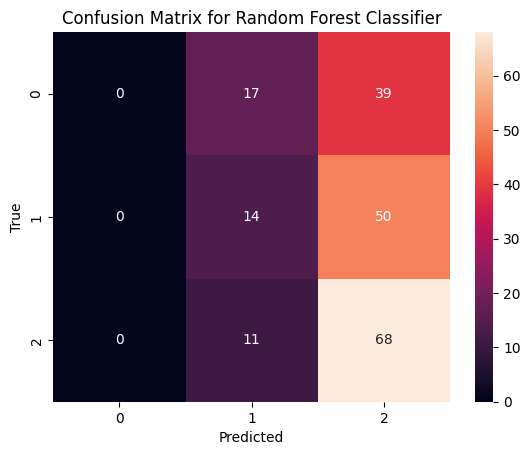

              precision    recall  f1-score   support

           D       0.00      0.00      0.00        56
           L       0.33      0.22      0.26        64
           W       0.43      0.86      0.58        79

    accuracy                           0.41       199
   macro avg       0.26      0.36      0.28       199
weighted avg       0.28      0.41      0.31       199



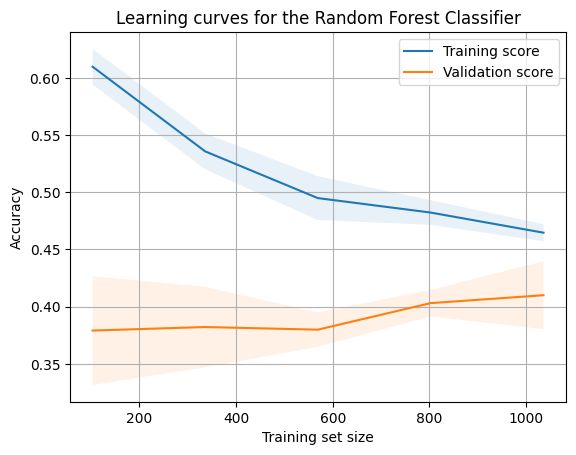

Feature Importances for Random Forest Classifier
1: elo_team2 - 0.25
2: average_('Standard', 'Sh')_last_x_team2 - 0.136
3: average_('Performance', 'Fls')_last_x_team2 - 0.134
4: average_('Short', 'Cmp')_last_x_team2 - 0.062
5: average_('1/3', '')_last_x_team1 - 0.054
6: average_('Carries', 'Carries')_last_x_team2 - 0.034
7: average_('Total', 'Cmp')_last_x_team2 - 0.026
8: average_('SCA Types', 'SCA')_last_x_team2 - 0.024
9: average_('Aerial Duels', 'Lost')_last_x_team2 - 0.022
10: average_('Carries', 'TotDist')_last_x_team2 - 0.02
11: average_('PrgP', '')_last_x_team1 - 0.018
12: average_('Touches', 'Att 3rd')_last_x_team1 - 0.016
13: average_('SCA Types', 'SCA')_last_x_team1 - 0.016
14: average_('Touches', 'Def Pen')_last_x_team1 - 0.014
15: average_('Tackles', 'TklW')_last_x_team2 - 0.012
16: average_('Touches', 'Att Pen')_last_x_team1 - 0.01
17: average_('Pass Types', 'Crs')_last_x_team2 - 0.01
18: average_('Standard', 'Sh')_last_x_team1 - 0.008
19: average_('Medium', 'Cmp')_last_x_

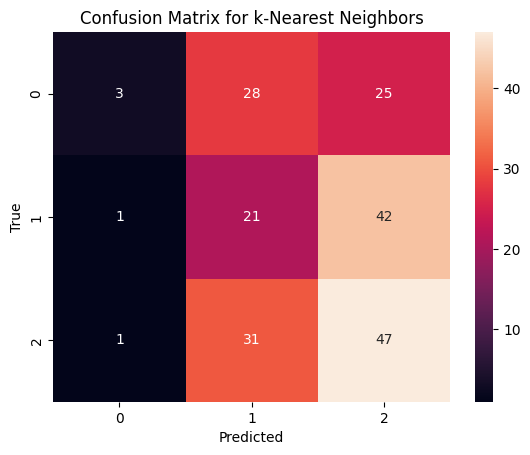

              precision    recall  f1-score   support

           D       0.60      0.05      0.10        56
           L       0.26      0.33      0.29        64
           W       0.41      0.59      0.49        79

    accuracy                           0.36       199
   macro avg       0.42      0.33      0.29       199
weighted avg       0.42      0.36      0.31       199



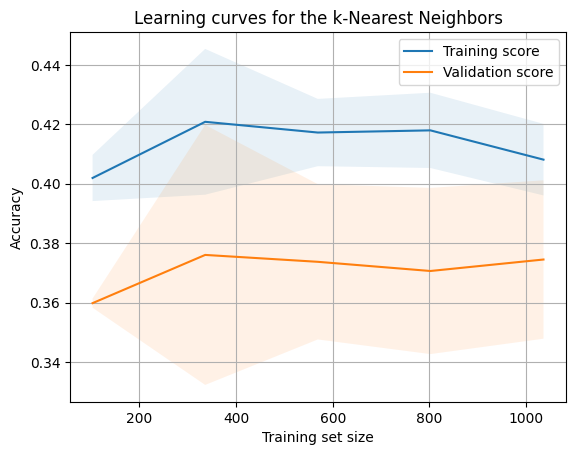

knn_model took 18.914939165115356 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.34673366834170855


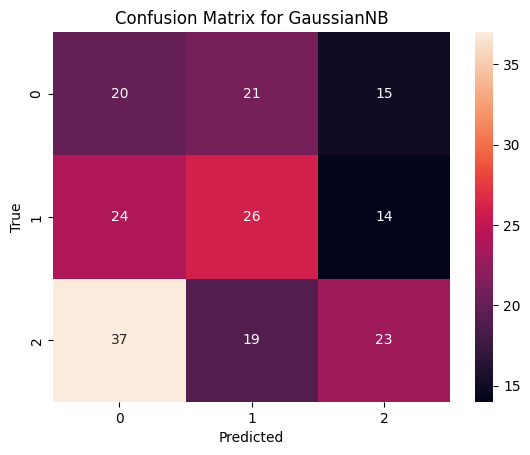

              precision    recall  f1-score   support

           D       0.25      0.36      0.29        56
           L       0.39      0.41      0.40        64
           W       0.44      0.29      0.35        79

    accuracy                           0.35       199
   macro avg       0.36      0.35      0.35       199
weighted avg       0.37      0.35      0.35       199



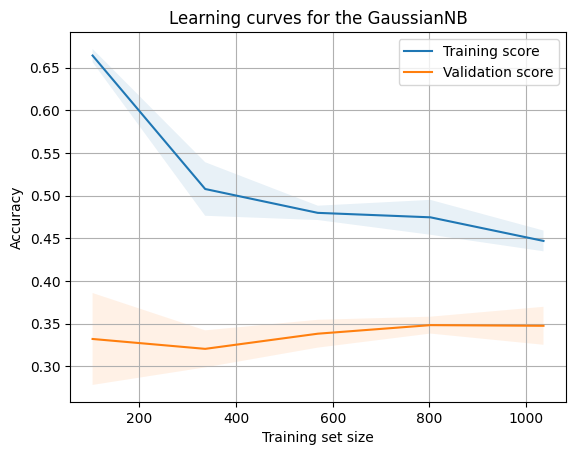

gnb_model took 0.2800464630126953 seconds
Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 5 matches average stats, but only the most important
Running Random Forest Classifier!
Best parameters: {'max_depth': 1, 'max_features': None, 'n_estimators': 75}
Best score: 0.4231660231660232
Accuracy on the testing data: 0.42857142857142855


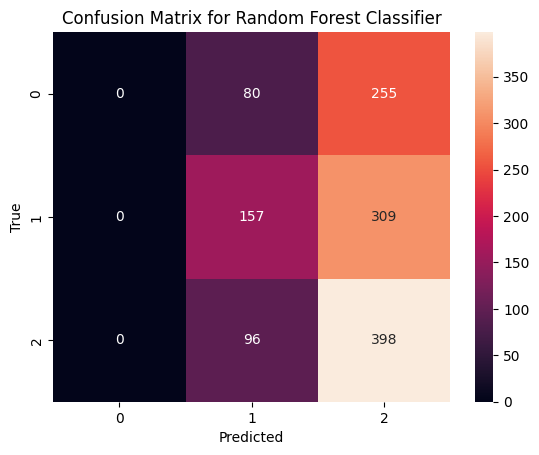

              precision    recall  f1-score   support

           D       0.00      0.00      0.00       335
           L       0.47      0.34      0.39       466
           W       0.41      0.81      0.55       494

    accuracy                           0.43      1295
   macro avg       0.30      0.38      0.31      1295
weighted avg       0.33      0.43      0.35      1295



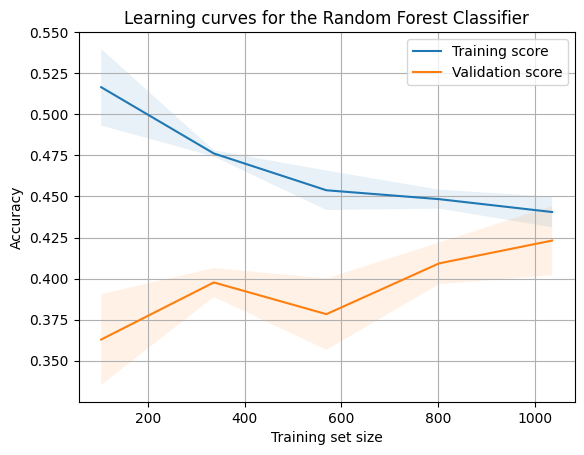

Feature Importances for Random Forest Classifier
1: elo_team2 - 0.4266666666666667
2: average_('Standard', 'Sh')_last_x_team2 - 0.22666666666666666
3: average_('SCA Types', 'SCA')_last_x_team1 - 0.10666666666666667
4: average_('SCA Types', 'SCA')_last_x_team2 - 0.10666666666666667
5: elo_team1 - 0.04
6: average_Poss_last_x_team2 - 0.02666666666666667
7: average_('Standard', 'Sh')_last_x_team1 - 0.013333333333333334
8: average_('GCA Types', 'GCA')_last_x_team2 - 0.013333333333333334
9: average_GA_last_x_team2 - 0.013333333333333334
10: Defenders_team2 - 0.013333333333333334
11: average_GF_last_x_team1 - 0.013333333333333334
12: average_Poss_last_x_team1 - 0.0
13: Defenders_team1 - 0.0
14: Forwards_team1 - 0.0
15: Midfielders_team1 - 0.0
16: Midfielders_team2 - 0.0
17: average_GA_last_x_team1 - 0.0
18: Forwards_team2 - 0.0
19: average_('GCA Types', 'GCA')_last_x_team1 - 0.0
20: average_GF_last_x_team2 - 0.0
run_RFC took 104.03768873214722 seconds
Running k-Nearest Neighbors!
Best paramet

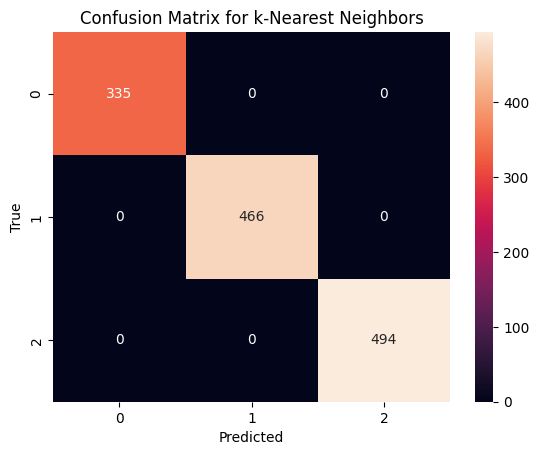

              precision    recall  f1-score   support

           D       1.00      1.00      1.00       335
           L       1.00      1.00      1.00       466
           W       1.00      1.00      1.00       494

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



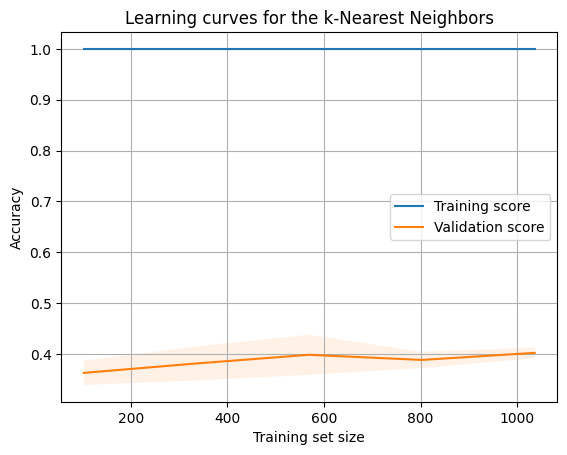

knn_model took 7.216821193695068 seconds
Running Gaussian Naive Bayes!
Accuracy on the testing data: 0.41235521235521233


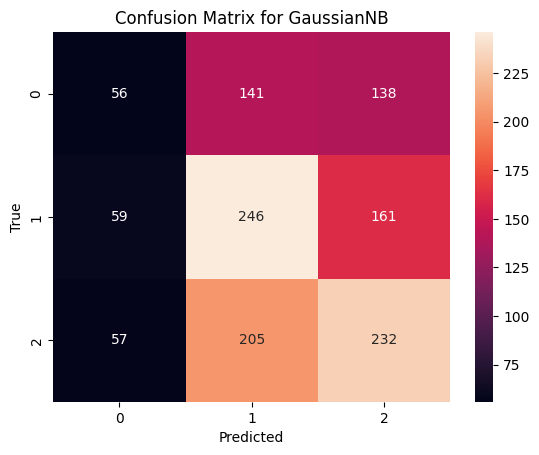

              precision    recall  f1-score   support

           D       0.33      0.17      0.22       335
           L       0.42      0.53      0.47       466
           W       0.44      0.47      0.45       494

    accuracy                           0.41      1295
   macro avg       0.39      0.39      0.38      1295
weighted avg       0.40      0.41      0.40      1295



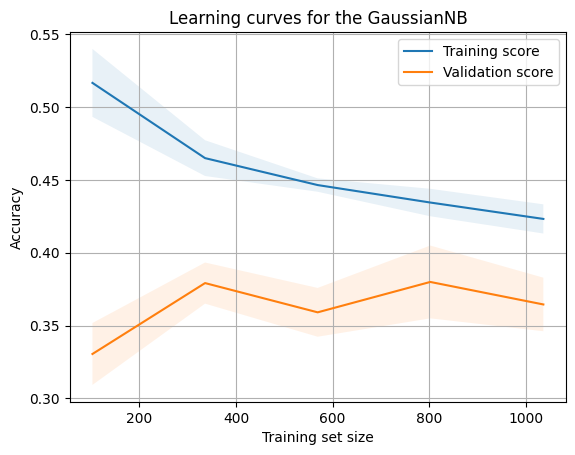

gnb_model took 0.25413060188293457 seconds


In [51]:
# Let's start with 5 matches average stats

print("ML models with 5 matches average stats")

# Dummy Classifier

# Assuming X and y are defined
x_dummy  = merged_df_5.drop(columns=['result_team1'])
y_dummy = merged_df_5[['result_team1']]

# Split the data into training and test sets
x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(x_dummy, y_dummy, test_size=0.2, random_state=42)

# Initialize the Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier to the training data
dummy_clf.fit(x_train_dummy, y_train_dummy)

# Make predictions on the test data
y_pred = dummy_clf.predict(x_test_dummy)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_dummy, y_pred)
print(f'Accuracy of Dummy Classifier: {accuracy}')


# Train/Test Split with date based split

train_data_5 = merged_df_5[merged_df_5['season_team1'] < 6]
test_data_5 = merged_df_5[merged_df_5['season_team1'] == 6]

#train_data = train_data.drop(columns=['season_team1'])
#test_data = test_data.drop(columns=['season_team1'])

print(train_data_5.shape)
print(test_data_5.shape)

X_train = train_data_5.drop(columns=['result_team1'])
X_test = test_data_5.drop(columns=['result_team1'])
Y_train = train_data_5['result_team1']
Y_test = test_data_5['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 5 matches average stats")
run_all_models(X_train, X_test, Y_train, Y_test)

# What if we use less average stats, only the most important?

train_data_5 = train_data_5[["season_team1","result_team1", "Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]
test_data_5 = train_data_5[["season_team1","result_team1","Defenders_team1","Forwards_team1","Midfielders_team1","elo_team1","average_Poss_last_x_team1","average_GF_last_x_team1","average_GA_last_x_team1","Defenders_team2","Forwards_team2","Midfielders_team2","elo_team2","average_Poss_last_x_team2","average_GF_last_x_team2","average_GA_last_x_team2","average_('SCA Types', 'SCA')_last_x_team2", "average_('GCA Types', 'GCA')_last_x_team2","average_('Standard', 'Sh')_last_x_team2","average_('SCA Types', 'SCA')_last_x_team1", "average_('GCA Types', 'GCA')_last_x_team1","average_('Standard', 'Sh')_last_x_team1"]]

X_train = train_data_5.drop(columns=['result_team1'])
X_test = test_data_5.drop(columns=['result_team1'])
Y_train = train_data_5['result_team1']
Y_test = test_data_5['result_team1']

print("Perfoemance of Random Forest Classifier, k-Nearest Neighbors and Gaussian Naive Bayes with 5 matches average stats, but only the most important")
run_all_models(X_train, X_test, Y_train, Y_test)

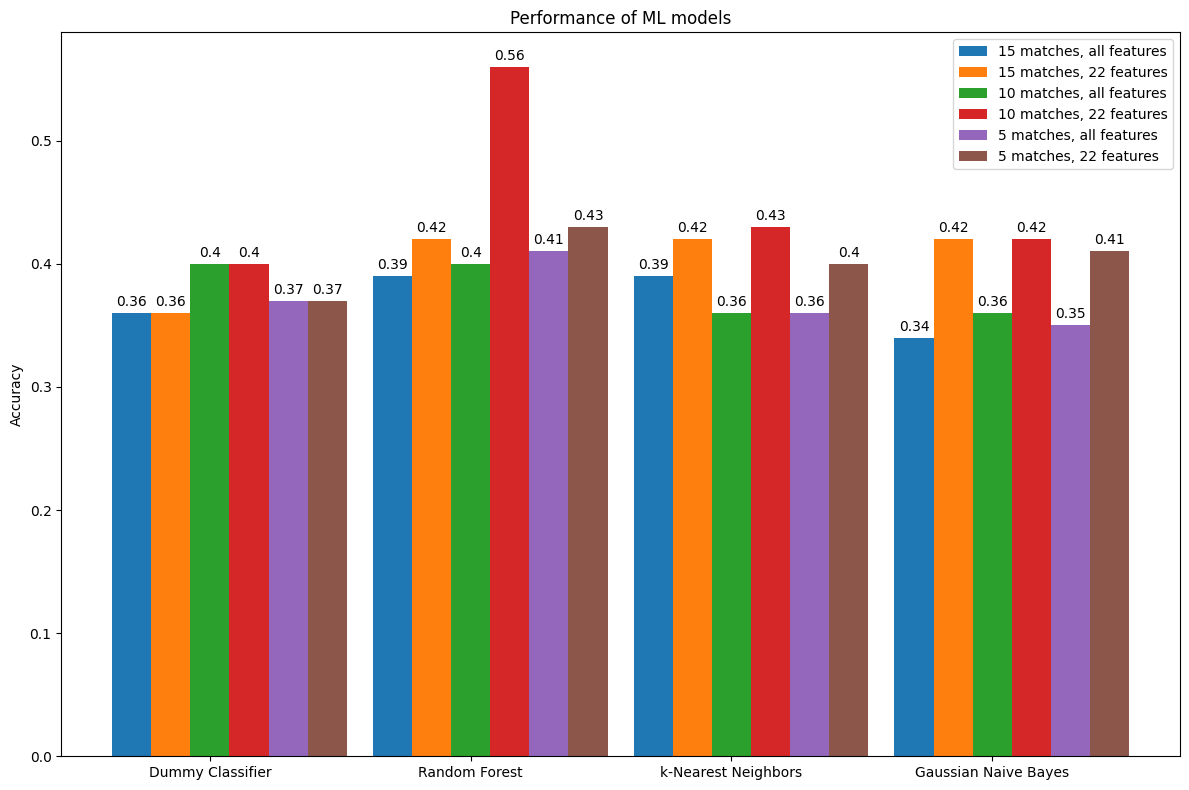

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Dummy Classifier', 'Random Forest', 'k-Nearest Neighbors', 'Gaussian Naive Bayes']

# Accuracy of models for different configurations
accuracy_15_all = [0.36, 0.39, 0.39, 0.34]
accuracy_15_22 = [0.36, 0.42, 0.42, 0.42]
accuracy_10_all = [0.40, 0.40, 0.36, 0.36]
accuracy_10_22 = [0.40, 0.56, 0.43, 0.42]
accuracy_5_all = [0.37, 0.41, 0.36, 0.35]
accuracy_5_22 = [0.37, 0.43, 0.40, 0.41]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - 2*width, accuracy_15_all, width, label='15 matches, all features')
rects2 = ax.bar(x - width, accuracy_15_22, width, label='15 matches, 22 features')
rects3 = ax.bar(x, accuracy_10_all, width, label='10 matches, all features')
rects4 = ax.bar(x + width, accuracy_10_22, width, label='10 matches, 22 features')
rects5 = ax.bar(x + 2*width, accuracy_5_all, width, label='5 matches, all features')
rects6 = ax.bar(x + 3*width, accuracy_5_22, width, label='5 matches, 22 features')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Performance of ML models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Custom function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

fig.tight_layout()

plt.show()